# Power spectra of precipitation and kinetic energy for MCS case

This notebook shows step by step how to get power spectra for 2D atmospheric fields using the Discrete Cosine Transformation. 

Contact: julia.kukulies@gu.se 

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr
from scipy import fft # package for transformation
from scipy import signal

# plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# my data analysis functions 
from dct_functions import k_to_lambda, get_variances, get_power_spectrum, lambda_to_k
from dct_functions import calculate_vorticity, subset_domain

In [3]:
from pathlib import Path
import numpy as np 
import xarray as xr
from scipy import fft # package for transformation
from scipy import signal
import sys
# sys.path.insert(1, '../analysis/')
# from cptp import analysis, plotting
# import seaborn as sns
# sns.set()

# plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
%matplotlib inline

# my data analysis functions 
from dct_functions import k_to_lambda, get_variances, get_power_spectrum, lambda_to_k
from dct_functions import calculate_vorticity, subset_domain

import warnings
warnings.filterwarnings('ignore')
import os
import glob
from netCDF4 import Dataset
from tqdm import tqdm
from pdb import set_trace as stop
import matplotlib.gridspec as gridspec
import string
abc_list = list(string.ascii_lowercase)

In [4]:
# DX = ['500M','250M','125M']
# DT = [2,1,0.5]
# dx_m = [500,250,125] 

# DX = ['12KM']
# DT = [32]
# dx_m = [12000] 

DX_all = ['12KM','4KM','2KM','1KM','500M','250M','125M']
DT_all = [32,16,8,4,2,1,0.5]
dx_m_all = [12000,4000,2000,1000,500,250,125] 

SIM_All = ['mao_20140401_15:00:00_',
        'mao_20140917_17:00:00_',
        'mao_20141004_13:00:00_',
        'mao_20141018_14:00:00_',
        'mao_20141117_18:00:00_',
        'mao_20141210_14:00:00_',
        'mao_20150328_15:00:00_',
        'mao_20150412_12:00:00_',
        'mao_20150621_14:00:00_',
        'mao_20151106_12:00:00_',
        'sgp_20120531_04:00:00_',
        'sgp_20120615_07:00:00_',
        'sgp_20130509_07:00:00_',
        'sgp_20130605_09:00:00_',
        'sgp_20130617_07:00:00_',
        'sgp_20140602_04:00:00_',
        'sgp_20140605_12:00:00_',
        'sgp_20140612_06:00:00_',
        'sgp_20140628_16:00:00_',
        'sgp_20140710_10:00:00_']
VARS = ['WW','QS','QR','QC','QG','QV','TK','P'] # virtual profiler variables
vwp_dir = '/glade/campaign/mmm/c3we/mingge/WRF_DOE/virtual_profiler_NetCDF/'
wrfout_dir = '/glade/campaign/mmm/c3we/mingge/WRF_DOE/'

skip_ml = '_ml-scip' # ['', '_ml-scip'] if yes --> 1 km arround the ML will be set to zero
direction = ['vertical', 'horizontal']
buffer = 0.5 # degrees from boundary of D2

for di in range(len(direction)):
    print('work on ' + direction[di])
    # save the data for later processing
    savedir ='/glade/campaign/mmm/c3we/prein/Papers/2023_Conv-Cores/data/spectra/'+direction[di]+'_spectra.npz'
    if os.path.isfile(savedir+'*') == 0:
        spectra_dir = {}
        for si in range(len(SIM_All)):
            print('    process '+str(si)+'-'+SIM_All[si])
            for dx in tqdm(range(len(DX_all))):
                SIM = SIM_All[si]
                dx_name = DX_all[dx] #'4KM' #str(sys.argv[1])
                sim_name = SIM+dx_name
                savedir_sim ='/glade/campaign/mmm/c3we/prein/Papers/2023_Conv-Cores/data/spectra/simulaitons/'+direction[di]+'_'+SIM_All[si]+'_'+DX_all[dx]+'_spectra_'+str(buffer)+'deg-buffer.npz'
                if os.path.isfile(savedir_sim) == 0:
                    

                    DX = [dx_name]
                    dx_sel =  DX_all.index(dx_name)

                    DT = [DT_all[dx_sel]]
                    dx_m = [dx_m_all[dx_sel]] 


                    # si = SIM_All.index('sgp_20120615_07:00:00_')
                    # SIM = SIM_All[si]
                    # Site = SIM[:3].upper()
                    
                    Site = SIM[:3].upper()


                    outdir = '/glade/campaign/mmm/c3we/prein/Papers/2023_Conv-Cores/data/core_stats'+skip_ml+'/'+SIM_All[si]+'/'
                    if not os.path.exists(outdir):
                        os.makedirs(outdir)

                    if np.isin(DX[0], ('500M','250M','125M')) == True:
                        subkm = True
                    else:
                        subkm = False


                    if subkm == True:
                        wrfout_files = np.sort(glob.glob(wrfout_dir+DX_all[dx_sel]+'/Thomson_YSU/'+SIM+DX_all[dx_sel]+'/wrfout_d02*'))
                    else:
                        if DX_all[dx_sel] != '12KM':
                            wrfout_files = np.sort(glob.glob(wrfout_dir+DX_all[dx_sel]+'/Thomson_YSU/'+SIM+'L'+DX_all[dx_sel][0]+'/wrfout_d01*'))
                        else:
                            wrfout_files = np.sort(glob.glob(wrfout_dir+DX_all[dx_sel]+'/Thomson_YSU_0/'+SIM+'L'+DX_all[dx_sel][:2]+'/wrfout_d01*'))
                        # only focus the analysis on 18 - 30 hours 
                        wrfout_files = wrfout_files[18*6+1:18*6+1+12*6]

                        # read d2 grid to cut out data from d1
                        if SIM[:3] == 'mao':
                            wrfout_d2 = '/glade/campaign/mmm/c3we/mingge/WRF_DOE/500M/Thomson_YSU/mao_20141210_14:00:00_500M/wrfout_d02_2014-12-10_12:40:00'
                        else:
                            wrfout_d2 = '/glade/campaign/mmm/c3we/mingge/WRF_DOE/500M/Thomson_YSU/sgp_20130617_07:00:00_500M/wrfout_d02_2013-06-17_04:20:00'

                        ncfile = Dataset(wrfout_d2)
                        lat_d2 = np.squeeze(ncfile.variables["XLAT"])
                        lon_d2 = np.squeeze(ncfile.variables['XLONG'])
                        ncfile.close()

                    if len(wrfout_files) == 0:
                        continue

                    ncfile = Dataset(wrfout_files[40])
                    lat = np.squeeze(ncfile.variables["XLAT"])
                    lon = np.squeeze(ncfile.variables['XLONG'])
                    ncfile.close()

                    if subkm == False:
                        # cut out d2 from d1
                        north = np.where(np.sum((lat <= np.max(lat_d2)-buffer), axis = 1) == 0)[0][0]
                        south = np.where(np.sum((lat <= np.min(lat_d2)+buffer), axis = 1) == 0)[0][0]
                        west = np.where(np.sum((lon <= np.min(lon_d2)+buffer), axis = 0) == 0)[0][0]
                        east = np.where(np.sum((lon <= np.max(lon_d2)-buffer), axis = 0) == 0)[0][0]
                        lat = lat[south:north, west:east]
                        lon = lon[south:north, west:east]    

                    # read the wind data
                    for fi in range(len(wrfout_files)):
                        ncfile = Dataset(wrfout_files[fi])
                        if direction[di] == 'vertical':
                            if subkm == False:
                                ww30 = np.squeeze(ncfile.variables['W'][:,30,south:north, west:east])
                                presh = np.squeeze(ncfile.variables['P'][:,30,south:north, west:east]) + np.squeeze(ncfile.variables['PB'][:,30,south:north, west:east])
                                temp = (np.squeeze(ncfile.variables['T'][:,30,south:north, west:east]) + 300) * (presh/100000)**0.2854
                            else:
                                ww30 = np.squeeze(ncfile.variables['W'][:,30,:,:])
                                presh = np.squeeze(ncfile.variables['P'][:,30,:,:]) + np.squeeze(ncfile.variables['PB'][:,30,:,:])
                                temp = (np.squeeze(ncfile.variables['T'][:,30,:,:]) + 300) * (presh/100000)**0.2854
                            air_density = presh/ (287.058 * temp)
                            kin_en = 1/2 * air_density * ww30**2
                        else:
                            if subkm == False:
                                uu30 = np.squeeze(ncfile.variables['U'][:,30,south:north, west:east])
                                vv30 = np.squeeze(ncfile.variables['V'][:,30,south:north, west:east])
                                presh = np.squeeze(ncfile.variables['P'][:,30,south:north, west:east]) + np.squeeze(ncfile.variables['PB'][:,30,south:north, west:east])
                                temp = (np.squeeze(ncfile.variables['T'][:,30,south:north, west:east]) + 300)  * (presh/100000)**0.2854
                            else:
                                uu30 = np.squeeze(ncfile.variables['U'][:,30,:,:])
                                vv30 = np.squeeze(ncfile.variables['V'][:,30,:,:])
                                uu30 = (uu30[:,:-1] + uu30[:,1:])/2
                                vv30 = (vv30[:-1,:] + vv30[1:,:])/2
                                presh = np.squeeze(ncfile.variables['P'][:,30,:,:]) + np.squeeze(ncfile.variables['PB'][:,30,:,:])
                                temp = (np.squeeze(ncfile.variables['T'][:,30,:,:]) + 300)  * (presh/100000)**0.2854
                            ww30 = (uu30**2 + vv30**2)**(1/2)
                            air_density = presh/ (287.058 * temp)
                            kin_en = 1/2 * air_density * ww30**2
                        ncfile.close()

                        # note: apply ortho normalization! 
                        WRF4kmprecip_spectral = fft.dctn(kin_en, norm="ortho")

                        # define number of grid cells in each direction 
                        Ni = kin_en.shape[0]
                        Nj = kin_en.shape[1]

                        WRF4kmvariance =  get_variances(WRF4kmprecip_spectral)
                        variance_field = (1/Ni )* (1/Nj)  * ( kin_en - np.nanmean(kin_en) )**2
                        total_variance1 = np.nansum(variance_field)

                        variance = WRF4kmvariance.copy()
                        variance[0,0] = np.nan
                        total_variance2 = np.nansum(variance)

                        lambda_rect = k_to_lambda(Ni, Nj, dx=dx_m_all[dx_sel])
                        WRF4kmwavelengths, WRF4kmhistogram = get_power_spectrum(WRF4kmvariance, dx = dx_m_all[dx_sel])

                        if fi == 0:
                            spectra = np.zeros((len(wrfout_files), len(WRF4kmhistogram)))
                        spectra[fi,:] = WRF4kmhistogram
                    # save the simulation data
                    np.savez(savedir_sim,
                           spectra = spectra,
                           WRF4kmwavelengths = WRF4kmwavelengths)
                else:
                    print('    load '+str(si)+'-'+SIM_All[si])
                    data_act = np.load(savedir_sim)
                    spectra = data_act['spectra']
                    WRF4kmwavelengths = data_act['WRF4kmwavelengths']
                    
                # save the spectra and wavelength to directory
                save_dir_act = {}
                save_dir_act['spectra'] = spectra
                save_dir_act['wavelength'] = WRF4kmwavelengths

                spectra_dir[sim_name] = save_dir_act

        np.savez(savedir, 
             spectra_dir=spectra_dir)
    else:
        data = np.load(savedir, allow_pickle=True)
        spectra_dir = data['spectra_dir'].item()
    if direction[di] == 'vertical':
        spectra_dir_vertical = spectra_dir
    elif direction[di] == 'horizontal':
        spectra_dir_horizontal = spectra_dir

work on vertical
    process 0-mao_20140401_15:00:00_


 29%|██▊       | 2/7 [00:00<00:00, 17.03it/s]

    load 0-mao_20140401_15:00:00_
    load 0-mao_20140401_15:00:00_
    load 0-mao_20140401_15:00:00_
    load 0-mao_20140401_15:00:00_
    load 0-mao_20140401_15:00:00_


100%|██████████| 7/7 [00:00<00:00, 10.45it/s]


    load 0-mao_20140401_15:00:00_
    load 0-mao_20140401_15:00:00_
    process 1-mao_20140917_17:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 1-mao_20140917_17:00:00_
    load 1-mao_20140917_17:00:00_


 29%|██▊       | 2/7 [00:00<00:01,  4.82it/s]

    load 1-mao_20140917_17:00:00_
    load 1-mao_20140917_17:00:00_


 57%|█████▋    | 4/7 [00:00<00:00,  4.97it/s]

    load 1-mao_20140917_17:00:00_
    load 1-mao_20140917_17:00:00_


100%|██████████| 7/7 [00:01<00:00,  6.84it/s]


    process 2-mao_20141004_13:00:00_


 57%|█████▋    | 4/7 [00:00<00:00, 34.68it/s]

    load 2-mao_20141004_13:00:00_
    load 2-mao_20141004_13:00:00_
    load 2-mao_20141004_13:00:00_
    load 2-mao_20141004_13:00:00_
    load 2-mao_20141004_13:00:00_
    load 2-mao_20141004_13:00:00_


100%|██████████| 7/7 [00:00<00:00, 34.79it/s]


    process 3-mao_20141018_14:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 17.98it/s]

    load 3-mao_20141018_14:00:00_
    load 3-mao_20141018_14:00:00_
    load 3-mao_20141018_14:00:00_
    load 3-mao_20141018_14:00:00_


100%|██████████| 7/7 [00:00<00:00, 21.63it/s]


    load 3-mao_20141018_14:00:00_
    load 3-mao_20141018_14:00:00_
    process 4-mao_20141117_18:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 4-mao_20141117_18:00:00_
    load 4-mao_20141117_18:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 24.43it/s]

    load 4-mao_20141117_18:00:00_
    load 4-mao_20141117_18:00:00_
    load 4-mao_20141117_18:00:00_
    load 4-mao_20141117_18:00:00_


100%|██████████| 7/7 [00:00<00:00, 29.60it/s]


    process 5-mao_20141210_14:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 5-mao_20141210_14:00:00_


100%|██████████| 7/7 [00:00<00:00, 15.79it/s]


    load 5-mao_20141210_14:00:00_
    load 5-mao_20141210_14:00:00_
    load 5-mao_20141210_14:00:00_
    load 5-mao_20141210_14:00:00_
    load 5-mao_20141210_14:00:00_
    process 6-mao_20150328_15:00:00_


100%|██████████| 7/7 [00:00<00:00, 34.14it/s]


    load 6-mao_20150328_15:00:00_
    load 6-mao_20150328_15:00:00_
    load 6-mao_20150328_15:00:00_
    load 6-mao_20150328_15:00:00_
    load 6-mao_20150328_15:00:00_
    load 6-mao_20150328_15:00:00_
    process 7-mao_20150412_12:00:00_


 57%|█████▋    | 4/7 [00:00<00:00, 20.18it/s]

    load 7-mao_20150412_12:00:00_
    load 7-mao_20150412_12:00:00_
    load 7-mao_20150412_12:00:00_
    load 7-mao_20150412_12:00:00_
    load 7-mao_20150412_12:00:00_


100%|██████████| 7/7 [00:00<00:00, 22.84it/s]


    load 7-mao_20150412_12:00:00_
    process 8-mao_20150621_14:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 8-mao_20150621_14:00:00_
    load 8-mao_20150621_14:00:00_
    load 8-mao_20150621_14:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 19.19it/s]

    load 8-mao_20150621_14:00:00_


100%|██████████| 7/7 [00:00<00:00, 21.22it/s]


    load 8-mao_20150621_14:00:00_
    load 8-mao_20150621_14:00:00_
    process 9-mao_20151106_12:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 9-mao_20151106_12:00:00_
    load 9-mao_20151106_12:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 24.37it/s]

    load 9-mao_20151106_12:00:00_
    load 9-mao_20151106_12:00:00_
    load 9-mao_20151106_12:00:00_
    load 9-mao_20151106_12:00:00_


100%|██████████| 7/7 [00:00<00:00, 20.17it/s]


    load 9-mao_20151106_12:00:00_
    process 10-sgp_20120531_04:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 10-sgp_20120531_04:00:00_
    load 10-sgp_20120531_04:00:00_


100%|██████████| 7/7 [00:00<00:00, 17.11it/s]


    load 10-sgp_20120531_04:00:00_
    load 10-sgp_20120531_04:00:00_
    load 10-sgp_20120531_04:00:00_
    load 10-sgp_20120531_04:00:00_
    process 11-sgp_20120615_07:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 11-sgp_20120615_07:00:00_


 57%|█████▋    | 4/7 [00:00<00:00, 33.69it/s]

    load 11-sgp_20120615_07:00:00_
    load 11-sgp_20120615_07:00:00_
    load 11-sgp_20120615_07:00:00_
    load 11-sgp_20120615_07:00:00_
    load 11-sgp_20120615_07:00:00_
    load 11-sgp_20120615_07:00:00_


100%|██████████| 7/7 [00:00<00:00, 25.63it/s]


    process 12-sgp_20130509_07:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 16.97it/s]

    load 12-sgp_20130509_07:00:00_
    load 12-sgp_20130509_07:00:00_
    load 12-sgp_20130509_07:00:00_
    load 12-sgp_20130509_07:00:00_


 71%|███████▏  | 5/7 [00:00<00:00, 13.72it/s]

    load 12-sgp_20130509_07:00:00_
    load 12-sgp_20130509_07:00:00_


100%|██████████| 7/7 [00:00<00:00, 16.99it/s]


    process 13-sgp_20130605_09:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 13-sgp_20130605_09:00:00_


 57%|█████▋    | 4/7 [00:00<00:00, 38.38it/s]

    load 13-sgp_20130605_09:00:00_
    load 13-sgp_20130605_09:00:00_
    load 13-sgp_20130605_09:00:00_
    load 13-sgp_20130605_09:00:00_
    load 13-sgp_20130605_09:00:00_


100%|██████████| 7/7 [00:00<00:00, 22.23it/s]


    process 14-sgp_20130617_07:00:00_


 57%|█████▋    | 4/7 [00:00<00:00, 35.78it/s]

    load 14-sgp_20130617_07:00:00_
    load 14-sgp_20130617_07:00:00_
    load 14-sgp_20130617_07:00:00_
    load 14-sgp_20130617_07:00:00_
    load 14-sgp_20130617_07:00:00_
    load 14-sgp_20130617_07:00:00_


100%|██████████| 7/7 [00:00<00:00, 33.69it/s]


    process 15-sgp_20140602_04:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 22.65it/s]

    load 15-sgp_20140602_04:00:00_
    load 15-sgp_20140602_04:00:00_
    load 15-sgp_20140602_04:00:00_
    load 15-sgp_20140602_04:00:00_
    load 15-sgp_20140602_04:00:00_


100%|██████████| 7/7 [00:00<00:00, 21.56it/s]


    load 15-sgp_20140602_04:00:00_
    process 16-sgp_20140605_12:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 16-sgp_20140605_12:00:00_
    load 16-sgp_20140605_12:00:00_
    load 16-sgp_20140605_12:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 23.66it/s]

    load 16-sgp_20140605_12:00:00_
    load 16-sgp_20140605_12:00:00_


100%|██████████| 7/7 [00:00<00:00, 23.99it/s]


    load 16-sgp_20140605_12:00:00_
    process 17-sgp_20140612_06:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 17-sgp_20140612_06:00:00_
    load 17-sgp_20140612_06:00:00_


 57%|█████▋    | 4/7 [00:00<00:00, 29.54it/s]

    load 17-sgp_20140612_06:00:00_
    load 17-sgp_20140612_06:00:00_
    load 17-sgp_20140612_06:00:00_
    load 17-sgp_20140612_06:00:00_


100%|██████████| 7/7 [00:00<00:00, 26.46it/s]


    load 17-sgp_20140612_06:00:00_
    process 18-sgp_20140628_16:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 18-sgp_20140628_16:00:00_
    load 18-sgp_20140628_16:00:00_
    load 18-sgp_20140628_16:00:00_
    load 18-sgp_20140628_16:00:00_


 71%|███████▏  | 5/7 [00:00<00:00, 40.47it/s]

    load 18-sgp_20140628_16:00:00_
    load 18-sgp_20140628_16:00:00_


100%|██████████| 7/7 [00:00<00:00, 41.93it/s]


    process 19-sgp_20140710_10:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 19-sgp_20140710_10:00:00_


 29%|██▊       | 2/7 [00:00<00:00, 18.19it/s]

    load 19-sgp_20140710_10:00:00_
    load 19-sgp_20140710_10:00:00_
    load 19-sgp_20140710_10:00:00_
    load 19-sgp_20140710_10:00:00_


 71%|███████▏  | 5/7 [00:00<00:00, 21.80it/s]

    load 19-sgp_20140710_10:00:00_


100%|██████████| 7/7 [00:00<00:00, 21.86it/s]


work on horizontal
    process 0-mao_20140401_15:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 0-mao_20140401_15:00:00_
    load 0-mao_20140401_15:00:00_


 71%|███████▏  | 5/7 [00:00<00:00, 15.49it/s]

    load 0-mao_20140401_15:00:00_
    load 0-mao_20140401_15:00:00_
    load 0-mao_20140401_15:00:00_
    load 0-mao_20140401_15:00:00_
    load 0-mao_20140401_15:00:00_


100%|██████████| 7/7 [00:00<00:00, 14.74it/s]


    process 1-mao_20140917_17:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 26.33it/s]

    load 1-mao_20140917_17:00:00_
    load 1-mao_20140917_17:00:00_
    load 1-mao_20140917_17:00:00_
    load 1-mao_20140917_17:00:00_
    load 1-mao_20140917_17:00:00_
    load 1-mao_20140917_17:00:00_


100%|██████████| 7/7 [00:00<00:00, 28.36it/s]


    process 2-mao_20141004_13:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 28.56it/s]

    load 2-mao_20141004_13:00:00_
    load 2-mao_20141004_13:00:00_
    load 2-mao_20141004_13:00:00_
    load 2-mao_20141004_13:00:00_
    load 2-mao_20141004_13:00:00_
    load 2-mao_20141004_13:00:00_


100%|██████████| 7/7 [00:00<00:00, 31.49it/s]


    process 3-mao_20141018_14:00:00_


 57%|█████▋    | 4/7 [00:00<00:00, 30.86it/s]

    load 3-mao_20141018_14:00:00_
    load 3-mao_20141018_14:00:00_
    load 3-mao_20141018_14:00:00_
    load 3-mao_20141018_14:00:00_
    load 3-mao_20141018_14:00:00_
    load 3-mao_20141018_14:00:00_


100%|██████████| 7/7 [00:00<00:00, 28.55it/s]


    process 4-mao_20141117_18:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 4-mao_20141117_18:00:00_
    load 4-mao_20141117_18:00:00_
    load 4-mao_20141117_18:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 22.19it/s]

    load 4-mao_20141117_18:00:00_
    load 4-mao_20141117_18:00:00_


100%|██████████| 7/7 [00:00<00:00, 29.01it/s]


    load 4-mao_20141117_18:00:00_
    process 5-mao_20141210_14:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 5-mao_20141210_14:00:00_
    load 5-mao_20141210_14:00:00_
    load 5-mao_20141210_14:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 28.93it/s]

    load 5-mao_20141210_14:00:00_
    load 5-mao_20141210_14:00:00_


 86%|████████▌ | 6/7 [00:00<00:00, 27.84it/s]

    load 5-mao_20141210_14:00:00_


100%|██████████| 7/7 [00:00<00:00, 32.20it/s]


    process 6-mao_20150328_15:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 6-mao_20150328_15:00:00_
    load 6-mao_20150328_15:00:00_
    load 6-mao_20150328_15:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 27.61it/s]

    load 6-mao_20150328_15:00:00_
    load 6-mao_20150328_15:00:00_
    load 6-mao_20150328_15:00:00_


100%|██████████| 7/7 [00:00<00:00, 30.54it/s]


    process 7-mao_20150412_12:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 7-mao_20150412_12:00:00_
    load 7-mao_20150412_12:00:00_
    load 7-mao_20150412_12:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 29.83it/s]

    load 7-mao_20150412_12:00:00_
    load 7-mao_20150412_12:00:00_
    load 7-mao_20150412_12:00:00_


100%|██████████| 7/7 [00:00<00:00, 29.79it/s]


    process 8-mao_20150621_14:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 8-mao_20150621_14:00:00_
    load 8-mao_20150621_14:00:00_
    load 8-mao_20150621_14:00:00_
    load 8-mao_20150621_14:00:00_


 57%|█████▋    | 4/7 [00:00<00:00, 30.41it/s]

    load 8-mao_20150621_14:00:00_
    load 8-mao_20150621_14:00:00_


100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


    process 9-mao_20151106_12:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 9-mao_20151106_12:00:00_
    load 9-mao_20151106_12:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 27.27it/s]

    load 9-mao_20151106_12:00:00_
    load 9-mao_20151106_12:00:00_
    load 9-mao_20151106_12:00:00_


 86%|████████▌ | 6/7 [00:00<00:00, 22.80it/s]

    load 9-mao_20151106_12:00:00_
    load 9-mao_20151106_12:00:00_


100%|██████████| 7/7 [00:00<00:00, 23.04it/s]


    process 10-sgp_20120531_04:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 10-sgp_20120531_04:00:00_
    load 10-sgp_20120531_04:00:00_
    load 10-sgp_20120531_04:00:00_
    load 10-sgp_20120531_04:00:00_


 57%|█████▋    | 4/7 [00:00<00:00, 29.31it/s]

    load 10-sgp_20120531_04:00:00_
    load 10-sgp_20120531_04:00:00_


100%|██████████| 7/7 [00:00<00:00, 33.84it/s]


    process 11-sgp_20120615_07:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 11-sgp_20120615_07:00:00_
    load 11-sgp_20120615_07:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 28.97it/s]

    load 11-sgp_20120615_07:00:00_
    load 11-sgp_20120615_07:00:00_
    load 11-sgp_20120615_07:00:00_


 86%|████████▌ | 6/7 [00:00<00:00, 22.59it/s]

    load 11-sgp_20120615_07:00:00_
    load 11-sgp_20120615_07:00:00_


100%|██████████| 7/7 [00:00<00:00, 22.38it/s]


    process 12-sgp_20130509_07:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 12-sgp_20130509_07:00:00_
    load 12-sgp_20130509_07:00:00_
    load 12-sgp_20130509_07:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 26.75it/s]

    load 12-sgp_20130509_07:00:00_
    load 12-sgp_20130509_07:00:00_
    load 12-sgp_20130509_07:00:00_


100%|██████████| 7/7 [00:00<00:00, 31.39it/s]


    process 13-sgp_20130605_09:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 13-sgp_20130605_09:00:00_
    load 13-sgp_20130605_09:00:00_
    load 13-sgp_20130605_09:00:00_


 57%|█████▋    | 4/7 [00:00<00:00, 33.78it/s]

    load 13-sgp_20130605_09:00:00_
    load 13-sgp_20130605_09:00:00_
    load 13-sgp_20130605_09:00:00_


100%|██████████| 7/7 [00:00<00:00, 27.02it/s]


    process 14-sgp_20130617_07:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 14-sgp_20130617_07:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 29.47it/s]

    load 14-sgp_20130617_07:00:00_
    load 14-sgp_20130617_07:00:00_
    load 14-sgp_20130617_07:00:00_
    load 14-sgp_20130617_07:00:00_
    load 14-sgp_20130617_07:00:00_


100%|██████████| 7/7 [00:00<00:00, 29.78it/s]


    process 15-sgp_20140602_04:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 29.67it/s]

    load 15-sgp_20140602_04:00:00_
    load 15-sgp_20140602_04:00:00_
    load 15-sgp_20140602_04:00:00_
    load 15-sgp_20140602_04:00:00_
    load 15-sgp_20140602_04:00:00_
    load 15-sgp_20140602_04:00:00_


100%|██████████| 7/7 [00:00<00:00, 31.61it/s]


    process 16-sgp_20140605_12:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 16-sgp_20140605_12:00:00_
    load 16-sgp_20140605_12:00:00_


100%|██████████| 7/7 [00:00<00:00, 19.60it/s]


    load 16-sgp_20140605_12:00:00_
    load 16-sgp_20140605_12:00:00_
    load 16-sgp_20140605_12:00:00_
    load 16-sgp_20140605_12:00:00_
    process 17-sgp_20140612_06:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 17-sgp_20140612_06:00:00_


 14%|█▍        | 1/7 [00:00<00:00,  7.73it/s]

    load 17-sgp_20140612_06:00:00_
    load 17-sgp_20140612_06:00:00_
    load 17-sgp_20140612_06:00:00_
    load 17-sgp_20140612_06:00:00_


100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


    load 17-sgp_20140612_06:00:00_
    load 17-sgp_20140612_06:00:00_
    process 18-sgp_20140628_16:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 18-sgp_20140628_16:00:00_


 57%|█████▋    | 4/7 [00:00<00:00, 35.42it/s]

    load 18-sgp_20140628_16:00:00_
    load 18-sgp_20140628_16:00:00_
    load 18-sgp_20140628_16:00:00_
    load 18-sgp_20140628_16:00:00_
    load 18-sgp_20140628_16:00:00_


100%|██████████| 7/7 [00:00<00:00, 30.03it/s]


    process 19-sgp_20140710_10:00:00_


  0%|          | 0/7 [00:00<?, ?it/s]

    load 19-sgp_20140710_10:00:00_
    load 19-sgp_20140710_10:00:00_
    load 19-sgp_20140710_10:00:00_


 43%|████▎     | 3/7 [00:00<00:00, 23.96it/s]

    load 19-sgp_20140710_10:00:00_
    load 19-sgp_20140710_10:00:00_
    load 19-sgp_20140710_10:00:00_

100%|██████████| 7/7 [00:00<00:00, 24.17it/s]


In [5]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [15]:
direction[::-1]

['horizontal', 'vertical']

        Plot map to: Kinetic-Energy-Spectra_vertical-horizontal.pdf


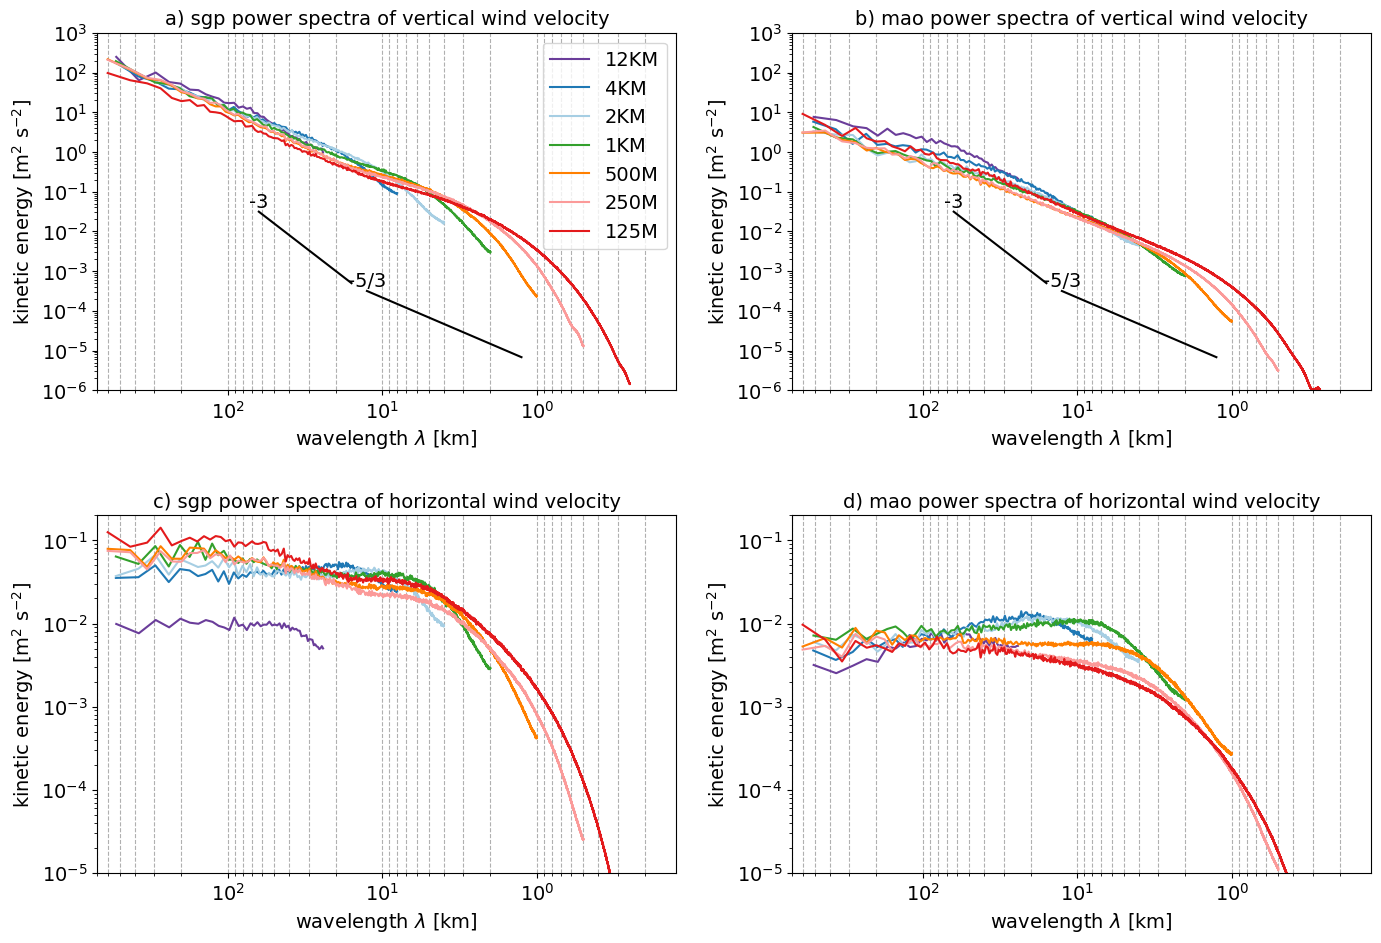

In [17]:
regions = ['sgp', 'mao']
colors = ['#6a3d9a','#1f78b4','#a6cee3','#33a02c','#ff7f00','#fb9a99','#e31a1c']
keys = np.array(list(spectra_dir.keys()))

fig = plt.figure(figsize=(14,10))
matplotlib.rcParams.update({'font.size': 14})
# Histogram plots
gs1 = gridspec.GridSpec(2,2) #rgiSize[2])
gs1.update(left=0.06, right=0.97,
           bottom=0.13, top=0.97,
           wspace=0.20, hspace=0.35)
for di in range(len(direction)):
    if direction[::-1][di] == 'vertical':
        spectra_dir = spectra_dir_vertical
        ylim = [10**-5,2*10**-1]
    elif direction[::-1][di] == 'horizontal':
        spectra_dir = spectra_dir_horizontal
        ylim = [10**-6,10**3]
    for re in range(len(regions)):
        ax = plt.subplot(gs1[di,re])

        re_act = regions[re]
        reg_sel = np.array([keys[ii][:3] == re_act for ii in range(len(keys))])
        keys_sel = keys[reg_sel]

        for dx in [0,1,2,3,4,5,6]:
            dx_act = DX_all[dx]
            dx_sel = np.array(['_' + dx_act in keys_sel[ii] for ii in range(len(keys_sel))])
            sim_sel = keys_sel[dx_sel]

            for si in range(len(sim_sel)):
                spectra_tmp = np.median(spectra_dir[sim_sel[si]]['spectra'], axis=0)
                if si == 0:
                    spectra_dx = np.zeros((len(sim_sel), len(spectra_tmp))); spectra_dx[:] = np.nan
                    spectra_dx[si,:] = spectra_tmp
                    wavelength_dx = spectra_dir[sim_sel[si]]['wavelength']
                else:
                    spectra_dx[si,:] = spectra_tmp

            plt.plot(wavelength_dx[1:]/1000., np.median(spectra_dx, axis=0), label = dx_act, color = colors[dx])

        plt.title(abc_list[re+di*2]+') '+regions[re] + ' power spectra of '+direction[di]+' wind velocity', fontsize= 14)
        plt.ylabel('kinetic energy [m$^{2}$ s$^{-2}$]')
        plt.xlabel('wavelength $\lambda$ [km]')
        plt.xscale('log')
        plt.yscale('log')
        plt.grid(True, which = 'both', axis = 'x', linestyle= '--')
        plt.ylim(ylim[0],ylim[1])
        plt.xlim(700,0.125)
        if (di == 0) & (re == 0):
            plt.legend()
            
        if di == 0:
            # -3 spectrum line
            x = np.logspace(1.8,1.2, 10)  # logarithmic x-axis values
            y = 0.2**(-3) * x**(-3)  # line equation with a slope of -3
            plt.loglog(x, y[::-1],c='k')
            plt.text(x[0],y[-1], '-3', ha='center', va='bottom')

            # -3 spectrum line
            x = np.logspace(1.1,0.1, 10)  # logarithmic x-axis values
            y = 100**(-5/3) * x**(-5/3)  # line equation with a slope of -3
            plt.loglog(x, y[::-1],c='k')
            plt.text(x[0],y[-1], '-5/3', ha='center', va='bottom')

sPlotFile=''
sPlotName= 'Kinetic-Energy-Spectra_vertical-horizontal.pdf'
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)

plt.show()

In [7]:
keys_sel

array(['mao_20140401_15:00:00_12KM', 'mao_20140401_15:00:00_4KM',
       'mao_20140401_15:00:00_2KM', 'mao_20140401_15:00:00_1KM',
       'mao_20140401_15:00:00_500M', 'mao_20140401_15:00:00_250M',
       'mao_20140401_15:00:00_125M', 'mao_20140917_17:00:00_12KM',
       'mao_20140917_17:00:00_4KM', 'mao_20140917_17:00:00_2KM',
       'mao_20140917_17:00:00_1KM', 'mao_20140917_17:00:00_500M',
       'mao_20140917_17:00:00_250M', 'mao_20141004_13:00:00_12KM',
       'mao_20141004_13:00:00_4KM', 'mao_20141004_13:00:00_2KM',
       'mao_20141004_13:00:00_1KM', 'mao_20141004_13:00:00_500M',
       'mao_20141004_13:00:00_250M', 'mao_20141018_14:00:00_12KM',
       'mao_20141018_14:00:00_4KM', 'mao_20141018_14:00:00_2KM',
       'mao_20141018_14:00:00_1KM', 'mao_20141018_14:00:00_500M',
       'mao_20141018_14:00:00_250M', 'mao_20141117_18:00:00_12KM',
       'mao_20141117_18:00:00_4KM', 'mao_20141117_18:00:00_2KM',
       'mao_20141117_18:00:00_1KM', 'mao_20141117_18:00:00_500M',
       'ma

In [8]:
1**(-3) * x**(-3)

array([5.01187234e-04, 1.07977516e-03, 2.32630507e-03, 5.01187234e-03,
       1.07977516e-02, 2.32630507e-02, 5.01187234e-02, 1.07977516e-01,
       2.32630507e-01, 5.01187234e-01])

In [9]:
spectra_tmp.shape

(5998,)

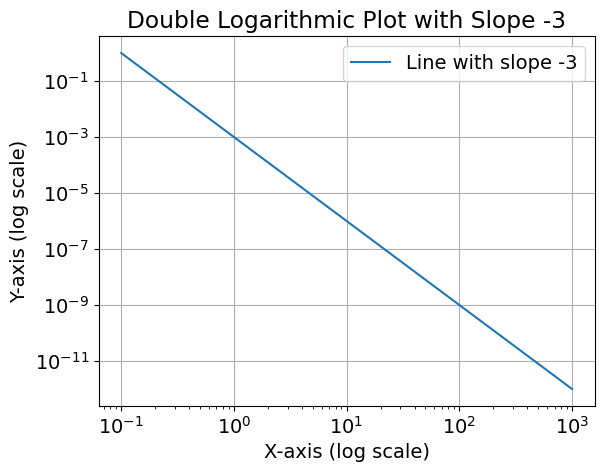

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data points for the line with a slope of -3
x = np.logspace(-1, 3, 100)  # logarithmic x-axis values
y = 10**(-3) * x**(-3)  # line equation with a slope of -3

# Create a double logarithmic plot
plt.loglog(x, y, label='Line with slope -3')

# Set labels and title
plt.xlabel('X-axis (log scale)')
plt.ylabel('Y-axis (log scale)')
plt.title('Double Logarithmic Plot with Slope -3')

# Show grid
plt.grid(True)

# Show legend
plt.legend()

# Display the plot
plt.show()


## Step 1. Discrete cosine transformation of vertical velocity field

! to perform a multidimensional DCT, take fft.dctn instead of fft.dct: https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dctn.html

In [11]:
plt.figure(figsize=(10,5))
plt.plot(wavelength_dx[1:], np.median(spectra_dx, axis=0), label = 'WRF4km', color ='crimson')
plt.title('Power spectra of mean rain rates', fontsize= 14)
plt.legend(fontsize= 12)
plt.ylabel(r'sum of variances $\sum \sigma^2$ [mm h$^{-1}]^2$')
plt.xlabel('wavelength $\lambda$ [m]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which = 'both', axis = 'x', linestyle= '--')

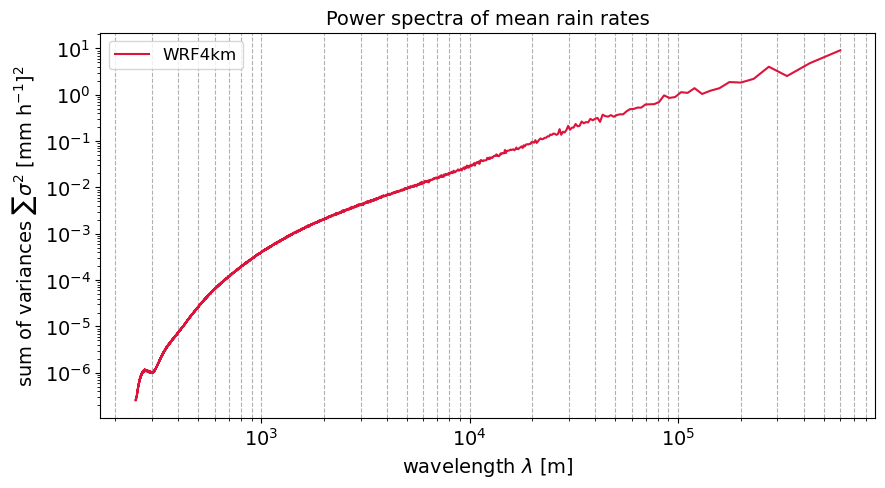

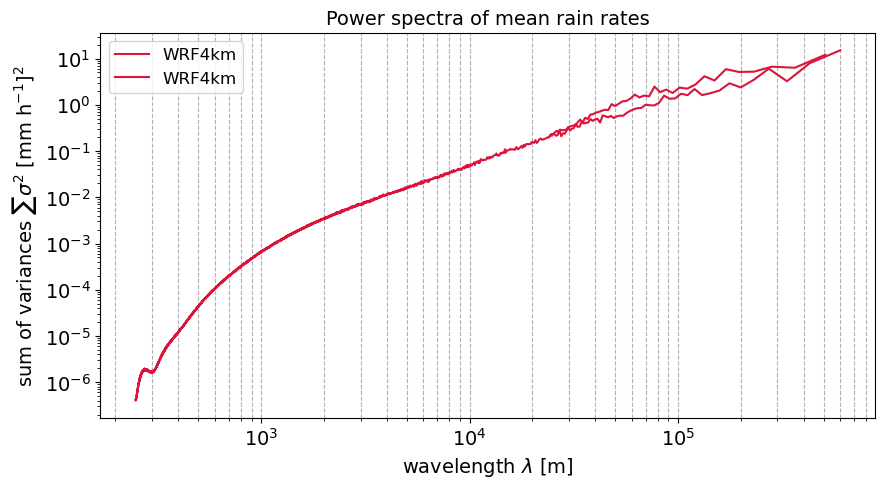

In [12]:
sim = 'mao_20140401_15:00:00_12KM'

plt.figure(figsize=(10,5))
plt.plot(spectra_dir[sim]['wavelength'][1:], np.median(spectra_dir[sim]['spectra'], axis=0), label = 'WRF4km', color ='crimson')
plt.title('Power spectra of mean rain rates', fontsize= 14)
plt.legend(fontsize= 12)
plt.ylabel(r'sum of variances $\sum \sigma^2$ [mm h$^{-1}]^2$')
plt.xlabel('wavelength $\lambda$ [m]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which = 'both', axis = 'x', linestyle= '--')

sim = 'mao_20140401_15:00:00_125M'

plt.plot(spectra_dir[sim]['wavelength'][1:], np.median(spectra_dir[sim]['spectra'], axis=0), label = 'WRF4km', color ='crimson')
plt.title('Power spectra of mean rain rates', fontsize= 14)
plt.legend(fontsize= 12)
plt.ylabel(r'sum of variances $\sum \sigma^2$ [mm h$^{-1}]^2$')
plt.xlabel('wavelength $\lambda$ [m]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which = 'both', axis = 'x', linestyle= '--')

plt.show()

In [13]:
stop()

--Call--
> /glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/IPython/core/displayhook.py(258)__call__()
    256         sys.stdout.flush()
    257 
--> 258     def __call__(self, result=None):
    259         """Printing with history cache management.
    260 



ipdb>  exit


### Verification 1: 

F(0,0) / $\sqrt{NiNj}$  should be equal to domain average of mean precip , with Ni and Nj being the total number of grid cells in each direction 

In [ ]:
assert np.isclose(WRF4kmprecip_spectral[0, 0] / np.sqrt(Ni * Nj), ww30.mean())
print(WRF4kmprecip_spectral[0, 0] / np.sqrt(Ni * Nj), ww30.mean())

In [ ]:
assert np.isclose(WRF4kmprecip_spectral[0, 0] / np.sqrt(Ni * Nj), ww30.mean())
print(WRF4kmprecip_spectral[0, 0] / np.sqrt(Ni * Nj), ww30.mean())

## Step 2. Variances of spectral coefficients


Get variances $\sigma^2$  = F(m,n) = F$^2$ / (NjNi) 

! think of normalization with domain size NjNi

In [ ]:
# my function to calculate normalized variances 
help(get_variances)

In [ ]:
WRF4kmvariance =  get_variances(WRF4kmprecip_spectral)

### Verification 2: 

total variance of spectral coefficients F(m,n)/NiNj (without F(0, 0), since this is the domain average ) should be same as total variance of precipitation values

In [ ]:
variance_field = (1/Ni )* (1/Nj)  * ( ww30 - np.nanmean(ww30) )**2
total_variance1 = np.nansum(variance_field)

variance = WRF4kmvariance.copy()
variance[0,0] = np.nan
total_variance2 = np.nansum(variance)

assert np.isclose(total_variance1, total_variance2)
print(total_variance1, total_variance2)

## Step 3. Get wavelengths for spectral space 

$\lambda$ = 2 * dx / $\alpha$, with $\alpha$ = $\sqrt{m^2 / Ni^2  + n^2 / Nj^2  }$

In this step, you also need to convert the indices m and n in the k-space to actual wavelengths. That way each spectral variance value is associated with one wavelength. 

In [ ]:
# my function to get real wavelengths
help(k_to_lambda)

In [ ]:
# convert non dimensional wavenumbers to wavelengths
lambda_rect = k_to_lambda(Ni, Nj, dx=4000)
# quick check if lambda values make sense 
plt.pcolormesh(lambda_rect, norm=LogNorm(10e3,10e4))
plt.colorbar(label = 'wavelength $\lambda$ [m]')
plt.show()

### Plot spectral variances as function of wavelengths 

In [ ]:
# horizontal and vertical lengths of 2D field
m, n   = np.meshgrid(np.arange(Nj), np.arange(Ni))

## plot
plt.figure(figsize=(10,5))
plt.pcolormesh(m, n, WRF4kmvariance, shading = 'auto', cmap = 'plasma' , norm=LogNorm(10e-5,10e1))
plt.title('spectral variances of precipitation field')


# get axes of spatial scales in km 
wavelength_x = lambda_rect[0,:]/ 1000
wavelength_y = lambda_rect[:,0]/ 1000
plt.xticks(m[0,:][1::150], (wavelength_x[1::150]).astype(int))
plt.yticks(n[:,0][1::100], (wavelength_y[1::100]).astype(int))

plt.xlabel('$\lambda$ [km]')
plt.ylabel('$\lambda$  [km]')
plt.colorbar(label ='$\sigma^2$ (m,n)')
plt.show()

## Step 4. Binning variances  $\sigma^2 (m,n)$ with specific wavelengths $\lambda$

- find the upper and lower bounds for radius k in which you want to sum the spectral variance values 
- sum of variances as function of the spatial scale give you an indication which scales are associated with largest variances
- useful to look at effective resolution of the models
- expected that the sum of variances for large wavelengths converges (see Big Brother experiment)

In [ ]:
# my function to get the power spectrum for a given 2D variance field 
help(get_power_spectrum)

In [ ]:
# use my function to compute power spectrum 
WRF4kmwavelengths, WRF4kmhistogram = get_power_spectrum(WRF4kmvariance, dx = dx_m_all[dx_sel])

### Plot power spectrum 

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(WRF4kmwavelengths[1:], WRF4kmhistogram, label = 'WRF4km', color ='crimson')
plt.title('Power spectra of mean rain rates', fontsize= 14)
plt.legend(fontsize= 12)
plt.ylabel(r'sum of variances $\sum \sigma^2$ [mm h$^{-1}]^2$')
plt.xlabel('wavelength $\lambda$ [m]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which = 'both', axis = 'x', linestyle= '--')
plt.show()

In [ ]:
stop()

# Comparison of mean power spectra for hourly/daily precipitation of different models, different model configurations and grid spacings 

Questions:
- What is the effective resolution of the models ? 
- How do the additional experiments like domain size and nudging effect the variance of rain rates at different scales? (e.g. lower variance due to smoother field of larger domain areas and nudging)? 

- In general a higher resolution results in higher variance 
- Most variance for larger scales due to different climatic zones (monsoon convection vs. desert)

### Load data for simulations to compare 

In [ ]:
campaign_storage= Path('/glade/campaign/mmm/c3we/prein/CPTP/data/CASES_Ensemble/MCS')
path= Path('/glade/scratch/kukulies/CPTP/')
datasets  = dict()


### WRF 4km ### 
datasets['WRF4km_d01']= campaign_storage/ 'pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc'
datasets['WRF4km_d02']= campaign_storage/ 'pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i2p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc'
datasets['WRF4km_d03'] =  path / '4km_5deg/postprocessed/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc'

#### WRF 12km ###
#datasets['WRF12km'] = '/glade/scratch/kukulies/wrf_processed/pr_CPTP-MCS-12_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc'
#### MPAS ###
#datasets['MPAS1'] = campaign_storage/ 'pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_PNNL-MPAS7.0P_v1_hour_20080714-20080724.nc'
#datasets['MPAS2'] = campaign_storage/ 'pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i3p1_PNNL-MPAS7.0P_v1_hour_20080714-20080724.nc'
#datasets['MPAS3'] = campaign_storage/ 'pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i3p1_PNNL-MPAS7.0P_v1_hour_20080714-20080724.nc'
datasets['MPAS'] = campaign_storage/ 'pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_PNNL-MPASLA7.0P_v1_hour_20080714-20080724.nc'

### CCLM ###
datasets['CCLM'] = campaign_storage/ 'pr_CPTP-MCS-2_ECMWF-ERA5_evaluation_r1i1p1_UIBK-CCLM50n1P_v1_hour_20080714-20080724.nc'
### ICON ###
datasets['ICON'] = campaign_storage/ 'pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_GUF-ICON2.6.3_v1_hour_20080714-20080724.nc'

### RegCM ###
datasets['RegCM'] = campaign_storage/ 'pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_IITM-RegCM480_v1_hour_20080714-20080724.nc'


### additional experiments ### 
datasets['WRF4km_nudging'] = path / '4km_spectral/postprocessed/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc'
#datasets['WRF4km_timelag'] = path / '4km_timelag/postprocessed/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc'


# vertical resolution experiment 
datasets['WRF8km'] = path / '8km_ref/postprocessed/pr_CPTP-MCS-8_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc'
datasets['WRF8km_vertical'] = path / '8km_vertical/postprocessed/pr_CPTP-MCS-8_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc'

#datasets['WRF12km'] = '/glade/scratch/kukulies/wrf_processed/pr_total_12km.nc'

### Compare to model terrain heights 

In [ ]:
from netCDF4 import Dataset
import wrf 
ds12km = Dataset('/glade/campaign/mmm/c3we/prein/CPTP/data/12km_casestudy-simulations/wrfout/wrfout_d01_2008-07-15_01:00:00')
ds4km = Dataset('/glade/campaign/mmm/c3we/prein/CPTP/data/4km_MCS_L/wrfout/wrfout_d01_2008-07-23_01:00:00')

terrain = dict()
terrain['WRF4km'] = wrf.getvar(ds4km, 'ter')
terrain['WRF12km'] = wrf.getvar(ds12km, 'ter') 

In [ ]:
wavelengths_terrain = dict()
histograms_terrain = dict()
wavelengths_terrain['WRF12km'] , histograms_terrain['WRF12km'] = power_spectrum_accumulations(ds=terrain['WRF12km'], dx=12)
wavelengths_terrain['WRF4km'] , histograms_terrain['WRF4km'] = power_spectrum_accumulations(ds=terrain['WRF4km'], dx=4)

### Median power spectra of precipitation accumulations in simulation 

In [ ]:
# get power spectrum for daily accumulated precip 
def power_spectrum_hourly(ds, dx):
    histogram= np.zeros((ds.Time.shape[0], ds.shape[1] - 2  )) 
    for idx, tt in enumerate(ds.Time.values):
        dayds= ds.sel(Time = tt)
        precip_spectral = fft.dctn(np.array(dayds.data), norm ='ortho')
        variance =  get_variances(precip_spectral)
        wavelengths, histogram[idx] = get_power_spectrum(variance, dx)
    return wavelengths, np.nanmedian(histogram , axis = 0)

In [ ]:
# get power spectrum for daily accumulated precip 
def power_spectrum_daily(ds, dx):
    histogram= np.zeros((ds.day.shape[0], ds.shape[1] - 2  )) 
    idx= 0 
    for dd in np.arange(16,22):
        dayds= ds.sel(day = dd)
        precip_spectral = fft.dctn(np.array(dayds.data), norm ='ortho')
        variance =  get_variances(precip_spectral)
        wavelengths, histogram[idx] = get_power_spectrum(variance, dx)
        idx +=1 
    return wavelengths, np.nanmedian(histogram , axis = 0)

In [ ]:
# get power spectrum for daily accumulated precip 
def power_spectrum_accumulations(ds, dx):
    precip_spectral = fft.dctn(np.array(ds.data), norm = 'ortho') 
    variance =  get_variances(precip_spectral)
    wavelengths, histogram = get_power_spectrum(variance, dx)
    return wavelengths, histogram 

In [ ]:
def subset_domain(ds, minlon, maxlon, minlat, maxlat, lonname, latname):
    """
    Subsets the domain of an xarray to given extent. 
    
    Args:
    ds(xarray.Dataset): xarray dataset which to crop 
    lonname(str): name of longitude dimension in dataset
    latname(str): name of latitude dimension in dataset 
    
    """
    mask_lon = (ds[lonname] >= minlon) & (ds[lonname] <= maxlon)
    mask_lat = (ds[latname] >= minlat) & (ds[latname] <= maxlat)
    
    cropped_ds = ds.where(mask_lon & mask_lat, drop=True)
    
    return cropped_ds

In [ ]:
#### total rainfall accumulations #### 
histograms = dict()
wavelengths = dict()
minlon, maxlon = 80,105
minlat, maxlat = 28,40

for key in datasets.keys():
    # get precip data in mm/d
    pr= xr.open_dataset(datasets[key]).pr * 3600
    cropped = subset_domain(pr , minlon, maxlon, minlat, maxlat, 'lon','lat')
    try:
        ds = cropped.mean('time')
    except:
        ds = cropped.mean('Time')

    # define different grid spacings for different datasets 
    if 'WRF' in key:
        dx = 4 
        if '12' in key: 
            dx  = 12
        elif '8' in key:
            dx = 8 
            
    if 'CCLM' in key: 
        dx = cclm_dx.mean()/1000
    if 'ICON' in key:
        dx = icon_dx.mean()/1000
    if 'RegCM' in key:
        dx = regcm_dx.mean()/1000
    if 'MPAS' in key:
        dx = mpas_dx.mean()/1000
    print(dx, key, cropped.shape)
    # get power spectrum for all datasets 
    wavelengths[key] , histograms[key] = power_spectrum_accumulations(ds=ds, dx=dx)

In [ ]:
#### spectra of hourly rain rates #### 

histograms = dict()
wavelengths = dict()

minlon, maxlon = 80,100
minlat, maxlat = 30,38

for key in datasets.keys():
    # get precip data in mm/d
    ds= xr.open_dataset(datasets[key])
    # get rain in mm/hr 
    pr = ds.pr * 3600
    # subset domain to make comparable 
    pr = subset_domain(pr , minlon, maxlon, minlat, maxlat, 'lon','lat')

    # define different grid spacings for different datasets 
    if '12' in key: 
        dx  = 12
    elif '8' in key:
        dx = 8 
    elif 'CCLM' in key: 
        dx = 2
    elif 'ICON' or 'MPAS' in key:
        dx = 3 
    else:
        dx = 4
    print(pr.shape, dx,key)
    # get power spectrum for all datasets 
    wavelengths[key] , histograms[key] = hourly_power_spectrum(ds=pr, dx=dx)

In [ ]:
icon_dx.mean()

In [ ]:
mpas_dx.mean()

In [ ]:
# get accurate grid spacing 
from metpy.calc import lat_lon_grid_deltas


mpas = xr.open_dataset(datasets['MPAS'])
dx, dy = lat_lon_grid_deltas(mpas.lon, mpas.lat)
mpas_dx  = np.array(dx[1:] + dy[:,:-1]) / 2 

icon= xr.open_dataset(datasets['ICON'])
dx, dy = lat_lon_grid_deltas(icon.lon, icon.lat)
icon_dx  = np.array(dx[1:] + dy[:,:-1]) / 2 

cclm = xr.open_dataset(datasets['CCLM'])
dx, dy = lat_lon_grid_deltas(cclm.lon, cclm.lat)
cclm_dx  = np.array(dx[1:] + dy[:,:-1]) / 2 

regcm = xr.open_dataset(datasets['RegCM'])
dx, dy = lat_lon_grid_deltas(regcm.lon, regcm.lat)
regcm_dx  = np.array(dx[1:] + dy[:,:-1]) / 2 

In [ ]:
#### daily accumulations #### 

histograms = dict()
wavelengths = dict()

minlon, maxlon = 75,100
minlat, maxlat = 29,40

for key in datasets.keys():
    # get precip data in mm/d
    ds= xr.open_dataset(datasets[key])
    pr = ds.pr * 3600
    pr = subset_domain(pr , minlon, maxlon, minlat, maxlat, 'lon','lat')
    if ds.time.values[0].dtype =='float64' :
        continue
    daily_acc_precip = pr.groupby(ds.time.dt.day).mean()
    
    # define different grid spacings for different datasets 
    if 'WRF' in key:
        dx = 4 
        if '12' in key: 
            dx  = 12
        elif '8' in key:
            dx = 8 
            
    if 'CCLM' in key: 
        dx = cclm_dx.mean()/1000
    if 'ICON' in key:
        dx = icon_dx.mean()/1000
    if 'RegCM' in key:
        dx = regcm_dx.mean()/1000
    if 'MPAS' in key:
        dx = mpas_dx.mean()/1000

    print(dx, key, pr.shape)
    # get power spectrum for all datasets 
    wavelengths[key] , histograms[key] = power_spectrum_daily(ds=daily_acc_precip, dx=dx)

In [ ]:
fsize = 22
lw = 2.4
idx= 0 
plt.figure(figsize=(18,8))
ax1= plt.subplot(1, 1, 1)

colors  = [ 'lightseagreen',  'dodgerblue', 'coral', 'crimson' ,'gold',  'tan', 'magenta', 'black', 'blue']

#### subplot to compare different models ####
for key in wavelengths.keys():
    if 'd03' in key or 'd02' in key or '12' in key:
        ax1.plot(wavelengths[key][1:], histograms[key], label = key, lw = lw, color = colors[idx])
        ax1.set_ylabel(r'sum of variances $\sum \sigma^2$ [mm d$^{-1}$]$^2$', fontsize = fsize )
        ax1.set_xlabel('wavelength $\lambda$ [km]', fontsize = fsize )
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        idx +=1 
plt.legend(fontsize= 20, loc = 'lower right')
        
### ADD TERRAIN 
lw = 2.0
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(wavelengths_terrain['WRF12km'][1:], histograms_terrain['WRF12km'], label = 'WRF12km terrain', lw = lw, color = 'k',linestyle = '-.')
ax2.plot(wavelengths_terrain['WRF4km'][1:], histograms_terrain['WRF4km'], label = 'WRF4km terrain', lw = lw, color = 'k')
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_xlim(0,1000)
xticks = [8,10,20,30,40,50,60,70,80,90,100,250,500, 1000]
ax2.set_xticks(xticks)
ax2.set_ylim(0,10**6)
ax2.set_xticklabels(xticks)
ax2.xaxis.grid(True)
ax2.yaxis.grid(False)
ax1.xaxis.grid(True, which ='minor')
ax1.yaxis.grid(False)
plt.legend(fontsize= 20, loc = 'lower center')

plt.savefig('plots/power_spectra_accumulations.png')
plt.show()

In [ ]:
fsize = 22
lw = 2.4
idx= 0 
plt.figure(figsize=(18,8))
ax1= plt.subplot(1, 1, 1)

colors  = [ 'lightseagreen',  'dodgerblue', 'coral', 'crimson' ,'gold',  'tan', 'magenta', 'black', 'blue']

#### subplot to compare different models ####
for key in wavelengths.keys():
    if 'd03' in key or 'd01' in key or 'd02' in key or '12' in key:
        ax1.plot(wavelengths[key][1:], histograms[key], label = key, lw = lw, color = colors[idx])
        ax1.set_ylabel(r'sum of variances $\sum \sigma^2$ [mm d$^{-1}$]$^2$', fontsize = fsize )
        ax1.set_xlabel('wavelength $\lambda$ [km]', fontsize = fsize )
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        idx +=1 
plt.legend(fontsize= 20, loc = 'lower right')
        
### ADD TERRAIN 
lw = 2.0
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(wavelengths_terrain['WRF12km'][1:], histograms_terrain['WRF12km'], label = 'WRF12km terrain', lw = lw, color = 'k',linestyle = '-.')
ax2.plot(wavelengths_terrain['WRF4km'][1:], histograms_terrain['WRF4km'], label = 'WRF4km terrain', lw = lw, color = 'k')
ax2.set_xscale('log')
ax2.set_yscale('log')

ax2.set_xlim(0,750)
xticks = [8,10,20,30,40,50,60,70,80,90,100,250,500, 750]
ax2.set_xticks(xticks)
ax2.set_ylim(0,10**6)
ax2.set_xticklabels(xticks)
ax2.xaxis.grid(True)
ax2.yaxis.grid(False)
ax1.xaxis.grid(True, which ='minor')
ax1.yaxis.grid(False)
plt.legend(fontsize= 20, loc = 'lower center')

plt.savefig('plots/power_spectra_accumulations.png')
plt.show()

In [ ]:
wavelengths.keys()

In [ ]:
histograms.keys()

In [ ]:
fsize = 22
lw = 2.0
import seaborn as sns
sns.set()
plt.figure(figsize=(10,8))
ax1= plt.subplot(1, 1, 1)
lw=3.0
colors =  ['mediumvioletred',  'plum', 'slateblue', 'lightblue', 'lightblue', 'lightseagreen','gray', 'darkslateblue', 'navy']
#### subplot to compare different models #### 
for idx,key in enumerate( ['WRF8km', 'WRF8km_vertical', 'WRF4km_d01', 'WRF4km_d02'] ):
    ax1.plot(wavelengths[key][1:], np.nanmedian(histograms[key] , axis =0), label = key, lw = lw, color = colors[idx])
    ax1.set_ylabel(r'sum of variances $\sum \sigma^2$ [mm d$^{-1}$]$^2$', fontsize = fsize )
    ax1.set_xlabel('wavelength $\lambda$ [km]', fontsize = fsize )
    ax1.set_xscale('log')
    ax1.set_yscale('log')

plt.grid(True, which = 'both', axis = 'x', linestyle= '--')
plt.legend(fontsize= 20)
plt.savefig('plots/power_spectrum_rainrates_MCS_WRF4-8km.png')
plt.show()

In [ ]:
fsize = 22
lw = 2.0
plt.figure(figsize=(10,8))
ax1= plt.subplot(1, 1, 1)

colors =  ['darkorange', 'lightcoral', 'plum', 'navajowhite', 'lightblue', 'lightseagreen','gray', 'darkslateblue', 'navy']
#### subplot to compare different models #### 
for idx,key in enumerate( ['WRF8km', 'WRF8km_vertical'] ):
    
    ax1.plot(wavelengths[key][1:], np.nanmedian(histograms[key] , axis =0), label = key, lw = lw, color = colors[idx])
    ax1.set_ylabel(r'sum of variances $\sum \sigma^2$ [mm d$^{-1}$]$^2$', fontsize = fsize )
    ax1.set_xlabel('wavelength $\lambda$ [km]', fontsize = fsize )
    ax1.set_xscale('log')
    ax1.set_yscale('log')

plt.grid(True, which = 'both', axis = 'x', linestyle= '--')
plt.legend(fontsize= 20)
plt.savefig('plots/power_spectrum_rainrates_MCS.png')
plt.show()

In [ ]:
#wrf4km_u = xr.open_dataset('/glade/scratch/kukulies/wrf_processed/WRF4km_MCS_L_u500hpa.nc').U_PL
#wrf4km_v = xr.open_dataset('/glade/scratch/kukulies/wrf_processed/WRF4km_MCS_L_v500hpa.nc').V_PL

In [ ]:
wrf8km_u = xr.open_dataset('/glade/scratch/kukulies/wrf_processed/WRF8km_ref_u500hpa.nc').U_PL
wrf8km_v = xr.open_dataset('/glade/scratch/kukulies/wrf_processed/WRF8km_ref_v500hpa.nc').V_PL
wrf8km_vertical_u = xr.open_dataset('/glade/scratch/kukulies/wrf_processed/WRF8km_vertical_u500hpa.nc').U_PL
wrf8km_vertical_v = xr.open_dataset('/glade/scratch/kukulies/wrf_processed/WRF8km_vertical_v500hpa.nc').V_PL

In [ ]:
# compute kinetic energy 
def get_ke(U, V, dx, resample = False):
    timedim = U.dims[0]
    histograms= np.zeros((V.shape[0], U.shape[1] - 2  )) 
    # get spectrum 
    for idx in np.arange(0, U[timedim].size): 
        u_wind = U[idx]
        v_wind = V[idx]
        KE = 0.5 * (u_wind**2 + v_wind**2)
        variances = get_variances(fft.dctn(np.array(KE.data), norm = 'ortho'))
        wavelengths, histograms[idx] = get_power_spectrum(variances, dx)
    return wavelengths, np.nanmedian(histograms, axis = 0 )

In [ ]:
wavelength_wrf8km, histogram_wrf8km = get_ke(wrf8km_u , wrf8km_v ,  dx = 8)
wavelength_wrf8kmv, histogram_wrf8kmv = get_ke(wrf8km_vertical_u, wrf8km_vertical_v,  dx = 8)

In [ ]:
fsize = 22
lw = 2.0
plt.figure(figsize=(10,8))
ax1= plt.subplot(1, 1, 1)
lw=3.0
colors =  ['mediumvioletred',  'plum',  'navajowhite', 'lightblue', 'lightseagreen','gray', 'darkslateblue', 'navy']

ax1.plot(wavelength_wrf8km[1:], histogram_wrf8km, label = 'WRF8km', lw = lw, color = colors[0])
ax1.plot(wavelength_wrf8kmv[1:], histogram_wrf8kmv, label = 'WRF8km_vertical', lw = lw, color = colors[1])
ax1.set_ylabel(r'Kinetic energy spectrum @500hpa [m$^2$ s$^{-2}$]', fontsize = fsize )
ax1.set_xlabel('wavelength $\lambda$ [km]', fontsize = fsize )
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.grid(True, which = 'both', axis = 'x', linestyle= '--')
plt.legend(fontsize= 20)
plt.show()

In [ ]:
fsize = 22
lw = 2.0
plt.figure(figsize=(18,8))
ax1= plt.subplot(1, 1, 1)

#### subplot to compare different models #### 
for idx,key in enumerate(wavelengths.keys()  ): 
        ax1.plot(wavelengths[key][1:], histograms[key], label = key, lw = lw)
        ax1.set_ylabel(r'sum of mean variances $\sum \sigma^2$ [mm d$^{-1}$]$^2$', fontsize = fsize )
        ax1.set_xlabel('wavelength $\lambda$ [km]', fontsize = fsize )
        ax1.set_xscale('log')
        ax1.set_yscale('log')
      
        
plt.grid(True, which = 'both', axis = 'x', linestyle= '--')
plt.legend(fontsize= 20)
plt.savefig('plots/power_spectra_accumulations_models.png')
plt.show()

- domains show same shape but different variance levels, due to smoother fields in the larger domain? 
- nudging and d01 converge for smaller wavelengths but diverge for larger wavelengths -> because large-scale field is smoothed 
- lowest variance in 12km simulation: smoothest field, effective resolution about 30 km 
- underestimation of large-scale variances for larger domains -> http://bluebook.meteoinfo.ru/uploads/2006/individual-articles/07_Leduc_Martin_07_Leduc_Martin_Regi_116F85.pdf
- or in fact overestimation of large-scale variance, because nudging forces variance at larger scales down 

### Median power spectra of hourly rain rates 

In [ ]:
# get power spectrum for each hourly timestep 
def hourly_power_spectrum(ds, dx):
    if 'time' in ds.dims: 
        time = ds.time.values
    elif 'Time' in ds.dims:
        time = ds.Time.values
    histogram= np.zeros((time.shape[0], ds.shape[1] - 2  )) 
    for idx,tt in enumerate(time):
        try:
            precip_spectral = fft.dctn(np.array(ds.sel(time = tt ).data), norm ='ortho')
        except:
            precip_spectral = fft.dctn(np.array(ds.sel(Time = tt ).data), norm ='ortho')
        
        variance =  get_variances(precip_spectral)
        wavelengths, histogram[idx] = get_power_spectrum(variance, dx)
        
    return wavelengths, histogram 

In [ ]:
#### hourly rain rates #### 
histograms = dict()
wavelengths = dict()

for key in datasets.keys():
    # get precip data in mm/hr 
    pr = xr.open_dataset(datasets[key]).pr * 3600 
    ds = subset_domain(pr, minlon, maxlon, minlat, maxlat, 'lon','lat')
    # define different grid spacings 
    if '12' in key: 
        dx  = 12
    elif 'CCLM' in key: 
        dx = 2.2
    elif 'MPAS' or 'ICON' in key:
        dx = mpas_dx.mean()/ 1000
    else:
        dx = 4
    # get power spectrum for all datasets 
    wavelengths[key] , histograms[key] = hourly_power_spectrum(ds=ds, dx=dx)

In [ ]:
import seaborn as sns 
sns.set()
fsize = 22
lw = 2.0
idx= 0 
plt.figure(figsize=(18,8))
ax1= plt.subplot(1, 1, 1)
ll = 0
colors  = ['lightseagreen',  'dodgerblue', 'slateblue', 'coral', 'gold', 'tan', 'crimson', 'black', 'mediumblue', 'gray',  'crimson', 'black', 'mediumblue', 'gray']
linestyles = ['-', '--', ':', '-.', '-.', '--']

#### subplot to compare different models #### 
for key in wavelengths.keys():
    if 'ICON' in key or 'RegCM' in key or 'MPAS' in key or 'WRF' in key or 'CCLM' in key:
        ax1.plot(wavelengths[key][1:], np.nanmedian(histograms[key], axis = 0) , label = key, lw = lw, color = colors[idx])
        ax1.set_ylabel(r'sum of mean variances $\sum \sigma^2$ [mm d$^{-1}$]$^2$', fontsize = fsize )
        ax1.set_xlabel('wavelength $\lambda$ [km]', fontsize = fsize )
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_title('Median power spectra of hourly rain rates', fontsize= fsize)
        idx +=1 

plt.legend(fontsize= 20)
    
### ADD TERRAIN 
#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#ax2.plot(wavelengths_terrain['WRF12km'][1:], histograms_terrain['WRF12km'], label = 'WRF12km terrain', lw = lw, color = 'k',linestyle = '--')
#ax2.plot(wavelengths_terrain['WRF4km'][1:], histograms_terrain['WRF4km'], label = 'WRF4km terrain', lw = lw, color = 'k')
#ax2.set_xscale('log')
#ax2.set_yscale('log')
#ax2.xaxis.grid(True)
#ax2.yaxis.grid(False)
#ax1.xaxis.grid(True, which ='minor')
#ax1.yaxis.grid(False)
    
    
plt.legend(fontsize= 20)
plt.grid(True, which = 'both', axis = 'x', linestyle= '--')
plt.savefig('plots/power_spectra_hourly_rain.png', transparent = False, facecolor = 'white', bbox_inches = 'tight')
plt.show()

# Power spectra of kinetic energy 

In [ ]:
#### get KE of ERA5 (takes time and does not need to be repeated since processed data is saved below) ####
import datetime
era = Path('/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/200807/')
u_files = list(era.glob('*_u.*nc'))
u_files.sort()
u_files = u_files[13:25]
v_files = list(era.glob('*_v.*nc'))
v_files.sort()
v_files = v_files[13:25]
lev = 200 
# get all days for simulation period at 500 hpa 
uwind = xr.open_dataset(u_files[0]).sel(level = 200)
vwind = xr.open_dataset(v_files[0]).sel(level = 200)
for idx in np.arange(len(u_files) - 1):
    ds = xr.open_dataset(u_files[idx + 1 ]).sel(level = 200)
    uwind = xr.concat([uwind, ds], dim = 'time')
    ds2= xr.open_dataset(v_files[idx + 1 ]).sel(level = 200)
    vwind = xr.concat([vwind, ds2], dim = 'time')
    
# subset to TP domain
uwind.to_netcdf('uwind_ERA5_200hpa.nc')
vwind.to_netcdf('vwind_ERA5_200hpa.nc')

In [ ]:
import xarray as xr 

In [ ]:
# subset to TP domain

minlon , maxlon = 75,115
minlat, maxlat = 25,40 

vwind = xr.open_dataset('vwind_ERA5.nc')
uwind = xr.open_dataset('uwind_ERA5.nc')
vwind = subset_domain(vwind, minlon, maxlon, minlat, maxlat, 'longitude', 'latitude')
uwind = subset_domain(uwind, minlon, maxlon, minlat, maxlat, 'longitude', 'latitude')


vwind200 = xr.open_dataset('vwind_ERA5_200hpa.nc')
uwind200 = xr.open_dataset('uwind_ERA5_200hpa.nc')
vwind200= subset_domain(vwind200, minlon, maxlon, minlat, maxlat, 'longitude', 'latitude')
uwind200 = subset_domain(uwind200, minlon, maxlon, minlat, maxlat, 'longitude', 'latitude')

In [ ]:
### WRF D02 ### 
wrf_dir = Path('/glade/campaign/mmm/c3we/prein/CPTP/data/')
wrf_files = list(wrf_dir.rglob('4km_MCS_L/wrfout/*PL*nc'))
wrf_files.sort()
wrfd02_u = xr.open_dataset(wrf_files[0]).U_PL.sel(num_press_levels_stag = 4)
wrfd02_v = xr.open_dataset(wrf_files[0]).V_PL.sel(num_press_levels_stag = 4)
for fname in wrf_files:
    ds = xr.open_dataset(fname).sel(num_press_levels_stag = 4)
    wrfd02_u = xr.concat([wrfd02_u, ds.U_PL ], dim = 'Time')
    wrfd02_v = xr.concat([wrfd02_v, ds.V_PL ], dim = 'Time')

In [ ]:
# WRF convective param
wrf_cum = xr.open_dataset('/glade/scratch/kukulies/wrf_processed/MCS_WRF4km_MSKF.nc')
wrf_cumu= wrf_cum.U_PL.squeeze()
wrf_cumv = wrf_cum.V_PL.squeeze()

wrf_noah = xr.open_dataset('/glade/scratch/kukulies/wrf_processed/MCS_WRF4km_Noah.nc')
wrf_noahu= wrf_noah.U_PL.squeeze()
wrf_noahv = wrf_noah.V_PL.squeeze()

ds = xr.open_dataset('/glade/campaign/mmm/c3we/prein/CPTP/data/4km_MCS/postprocessed/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc')
wrfd02_lats = ds.lat
wrfd02_lons = ds.lon


wrf_cumu= wrf_cumu.where( (wrfd02_lats > minlat) &  (wrfd02_lats< maxlat) &  (wrfd02_lons > minlon) & (wrfd02_lons < maxlon), drop = True)
wrf_cumv= wrf_cumv.where( (wrfd02_lats > minlat) &  (wrfd02_lats< maxlat) &  (wrfd02_lons > minlon) & (wrfd02_lons < maxlon), drop = True)

wrf_noahu= wrf_noahu.where( (wrfd02_lats > minlat) &  (wrfd02_lats< maxlat) &  (wrfd02_lons > minlon) & (wrfd02_lons < maxlon), drop = True)
wrf_noahv= wrf_noahv.where( (wrfd02_lats > minlat) &  (wrfd02_lats< maxlat) &  (wrfd02_lons > minlon) & (wrfd02_lons < maxlon), drop = True)

wavelength_wrfd01, histogram_wrfcum = get_ke(wrf_cumu, wrf_cumv, dx = 4, resample = True)
wavelength_wrfd01, histogram_wrfnoah = get_ke(wrf_noahu, wrf_noahv, dx = 4, resample = True)

In [ ]:
### WRF D02 ### 
wrf_dir = Path('/glade/campaign/mmm/c3we/prein/CPTP/data/')
wrf_files = list(wrf_dir.rglob('4km_MCS_L/wrfout/*PL*nc'))
wrf_files.sort()
wrfd02_u200 = xr.open_dataset(wrf_files[0]).U_PL.sel(num_press_levels_stag = 5)
wrfd02_v200 = xr.open_dataset(wrf_files[0]).V_PL.sel(num_press_levels_stag = 5)
for fname in wrf_files:
    ds = xr.open_dataset(fname).sel(num_press_levels_stag = 5)
    wrfd02_u200 = xr.concat([wrfd02_u200, ds.U_PL ], dim = 'Time')
    wrfd02_v200 = xr.concat([wrfd02_v200, ds.V_PL ], dim = 'Time')

In [ ]:
### CCLM ###
cclm_dir = Path('/glade/scratch/kukulies/CCLM/')
dscclm = xr.open_dataset(cclm_dir / 'uv_500hPa_CPTP-MCS-2.2_ECMWF-ERA5_evaluation_r1i1p1_UIBK-CCLM5.0n1P_v1_3h_20080714-20080724_cropped.nc')
cclm_u = dscclm.U
cclm_v = dscclm.V

dscclm = xr.open_dataset(cclm_dir / 'uv_500hPa_CPTP-MCS-12_ECMWF-ERA5_evaluation_r1i1p1_UIBK-CCLM5.0n1P_v1_3h_20080714-20080724_cropped.nc')
cclm_u12 = dscclm.U
cclm_v12 = dscclm.V


dscclm = xr.open_dataset(cclm_dir / 'uv_200hPa_CPTP-MCS-2.2_ECMWF-ERA5_evaluation_r1i1p1_UIBK-CCLM5.0n1P_v1_3h_20080714-20080724_cropped.nc')
cclm_u200 = dscclm.U
cclm_v200 = dscclm.V

dscclm = xr.open_dataset(cclm_dir / 'uv_200hPa_CPTP-MCS-12_ECMWF-ERA5_evaluation_r1i1p1_UIBK-CCLM5.0n1P_v1_3h_20080714-20080724_cropped.nc')
cclm_u200_12 = dscclm.U
cclm_v200_12= dscclm.V

In [ ]:
def lat_lon_grid_deltas(longitude, latitude, x_dim=-1, y_dim=-2, geod=None):
    r"""Calculate the actual delta between grid points that are in latitude/longitude format.
    Parameters
    ----------
    longitude : array_like
        Array of longitudes defining the grid. If not a `pint.Quantity`, assumed to be in
        degrees.
    latitude : array_like
        Array of latitudes defining the grid. If not a `pint.Quantity`, assumed to be in
        degrees.
    x_dim: int
        axis number for the x dimension, defaults to -1.
    y_dim : int
        axis number for the y dimension, defaults to -2.
    geod : `pyproj.Geod` or ``None``
        PyProj Geod to use for forward azimuth and distance calculations. If ``None``, use a
        default spherical ellipsoid.
    Returns
    -------
    dx, dy:
        At least two dimensional arrays of signed deltas between grid points in the x and y
        direction
    Notes
    -----
    Accepts 1D, 2D, or higher arrays for latitude and longitude
    Assumes [..., Y, X] dimension order for input and output, unless keyword arguments `y_dim`
    and `x_dim` are otherwise specified.
    This function will only return `pint.Quantity` arrays (not `xarray.DataArray` or another
    array-like type). It will also "densify" your data if using Dask or lazy-loading.
    .. versionchanged:: 1.0
       Changed signature from ``(longitude, latitude, **kwargs)``
    """
    # Inputs must be the same number of dimensions
    if latitude.ndim != longitude.ndim:
        raise ValueError('Latitude and longitude must have the same number of dimensions.')

    # If we were given 1D arrays, make a mesh grid
    if latitude.ndim < 2:
        longitude, latitude = np.meshgrid(longitude, latitude)

    # pyproj requires ndarrays, not Quantities
    try:
        longitude = np.asarray(longitude.m_as('degrees'))
        latitude = np.asarray(latitude.m_as('degrees'))
    except AttributeError:
        longitude = np.asarray(longitude)
        latitude = np.asarray(latitude)

    # Determine dimension order for offset slicing
    take_y = make_take(latitude.ndim, y_dim)
    take_x = make_take(latitude.ndim, x_dim)

    g = Geod(ellps='sphere') if geod is None else geod
    forward_az, _, dy = g.inv(longitude[take_y(slice(None, -1))],
                              latitude[take_y(slice(None, -1))],
                              longitude[take_y(slice(1, None))],
                              latitude[take_y(slice(1, None))])
    dy[(forward_az < -90.) | (forward_az > 90.)] *= -1

    forward_az, _, dx = g.inv(longitude[take_x(slice(None, -1))],
                              latitude[take_x(slice(None, -1))],
                              longitude[take_x(slice(1, None))],
                              latitude[take_x(slice(1, None))])
    dx[(forward_az < 0.) | (forward_az > 180.)] *= -1

    return dx, dy

In [ ]:

def make_take(ndims, slice_dim):
    """Generate a take function to index in a particular dimension."""
    def take(indexer):
        return tuple(indexer if slice_dim % ndims == i else slice(None)  # noqa: S001
                     for i in range(ndims))
    return take

from pyproj import Geod

In [ ]:
latlon = xr.open_dataset('/glade/campaign/mmm/c3we/prein/CPTP/data/CASES_Ensemble/MCS/pr_CPTP-MCS-2_ECMWF-ERA5_evaluation_r1i1p1_UIBK-CCLM50n1P_v1_hour_20080714-20080724.nc')

cclm_lats = latlon.lat
cclm_lons = latlon.lon
#from metpy.calc import lat_lon_grid_deltas
dx, dy = lat_lon_grid_deltas(cclm_lons, cclm_lats, geod = None)

In [ ]:
### MPAS 500 hpa ### 
mpas_dir = Path('/glade/scratch/kukulies/MPAS/')
mpas_u = xr.open_dataset(mpas_dir / 'ua500_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_PNNL-MPASLA7.0P_v1_3hour_20080714-20080724.nc').ua500
mpas_v = xr.open_dataset(mpas_dir / 'va500_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_PNNL-MPASLA7.0P_v1_3hour_20080714-20080724.nc').va500

In [ ]:
### MPAS 200 hpa### 
mpas_dir = Path('/glade/scratch/kukulies/MPAS/')
mpas_u200 = xr.open_dataset(mpas_dir / 'ua200_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_PNNL-MPASLA7.0P_v1_3hour_20080714-20080724.nc').ua200
mpas_v200 = xr.open_dataset(mpas_dir / 'va200_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_PNNL-MPASLA7.0P_v1_3hour_20080714-20080724.nc').va200

In [ ]:
### ICON ### 
icon_dir = Path('/glade/scratch/kukulies/ICON/')
icon_u = xr.open_dataset(icon_dir / 'ua500_CPTP-MCS-3_ECMWF-ERA5_evaluation_r1i1p1_IAP-CAS-ICON2.6.1P_v1_hour_20080714-20080724.nc')
icon_v = xr.open_dataset(icon_dir / 'va500_CPTP-MCS-3_ECMWF-ERA5_evaluation_r1i1p1_IAP-CAS-ICON2.6.1P_v1_hour_20080714-20080724.nc')
icon_u200 = xr.open_dataset(icon_dir / 'ua200_CPTP-MCS-3_ECMWF-ERA5_evaluation_r1i1p1_IAP-CAS-ICON2.6.1P_v1_hour_20080714-20080724.nc')
icon_v200 = xr.open_dataset(icon_dir / 'va200_CPTP-MCS-3_ECMWF-ERA5_evaluation_r1i1p1_IAP-CAS-ICON2.6.1P_v1_hour_20080714-20080724.nc')

In [ ]:
### ICON GUF ### 
icon_dir = Path('/glade/campaign/mmm/c3we/prein/CPTP/data/CASES_Ensemble/MCS/')
icon_guf_u = xr.open_dataset(icon_dir / 'ua500_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_GUF-ICON2.6.3_v1_hour_20080714-20080724.nc')
icon_guf_v = xr.open_dataset(icon_dir / 'va500_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_GUF-ICON2.6.3_v1_hour_20080714-20080724.nc')

icon_guf_u200 = xr.open_dataset(icon_dir / 'ua200_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_GUF-ICON2.6.3_v1_hour_20080714-20080724.nc')
icon_guf_v200 = xr.open_dataset(icon_dir / 'va200_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_GUF-ICON2.6.3_v1_hour_20080714-20080724.nc')

icon_guf_u = icon_guf_u.where( (icon_guf_u.lat > minlat) &  (icon_guf_u.lat < maxlat) &  (icon_guf_u.lon > minlon) & (icon_guf_u.lon < maxlon), drop = True)
icon_guf_v = icon_guf_v.where( (icon_guf_v.lat > minlat) &  (icon_guf_v.lat < maxlat) &  (icon_guf_v.lon > minlon) & (icon_guf_v.lon < maxlon), drop = True)


icon_guf_u200 = icon_guf_u200.where( (icon_guf_u.lat > minlat) &  (icon_guf_u.lat < maxlat) &  (icon_guf_u.lon > minlon) & (icon_guf_u.lon < maxlon), drop = True)
icon_guf_v200 = icon_guf_v200.where( (icon_guf_v.lat > minlat) &  (icon_guf_v.lat < maxlat) &  (icon_guf_v.lon > minlon) & (icon_guf_v.lon < maxlon), drop = True)

In [ ]:
### RegCM 200 hpa ### 
regcm_dir = Path('/glade/scratch/kukulies/RegCM')
ds = xr.open_dataset(regcm_dir / 'ua200_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_IITM-RegCM480_v1_hour_20080714-20080724_subset2.nc')
regcm_u200 = ds.ua200
regcm_lats = ds.lat
regcm_lons = ds.lon
regcm_v200 = xr.open_dataset(regcm_dir / 'va200_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_IITM-RegCM480_v1_hour_20080714-20080724_subset2.nc').va200

In [ ]:
### RegCM 500 hpa ### 
regcm_dir = Path('/glade/scratch/kukulies/RegCM')
ds = xr.open_dataset(regcm_dir / 'ua500_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_IITM-RegCM480_v1_hour_20080714-20080724_subset2.nc')
regcm_u = ds.ua500
regcm_lats = ds.lat
regcm_lons = ds.lon
regcm_v = xr.open_dataset(regcm_dir / 'va500_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i1p1_IITM-RegCM480_v1_hour_20080714-20080724_subset2.nc').va500

In [ ]:
### WRF 12km 200 hpa###
wrf_dir = Path('/glade/campaign/mmm/c3we/prein/CPTP/data/12km_casestudy-simulations/')
wrf_files = list(wrf_dir.rglob('wrfout/*PL*2008-07*nc'))
wrf_files.sort()
wrf_files = wrf_files[13:25]
wrf12km_u200 = xr.open_dataset(wrf_files[0]).U_PL.sel(num_press_levels_stag = 5)
wrf12km_v200 = xr.open_dataset(wrf_files[0]).V_PL.sel(num_press_levels_stag = 5)
for fname in wrf_files:
    ds = xr.open_dataset(fname).sel(num_press_levels_stag = 5)
    wrf12km_u200= xr.concat([wrf12km_u200, ds.U_PL ], dim = 'Time')
    wrf12km_v200 = xr.concat([wrf12km_v200, ds.V_PL ], dim = 'Time')

In [ ]:
### WRF 12km 500 hpa###
wrf_files = list(wrf_dir.rglob('wrfout/*PL*2008-07*nc'))
wrf_files.sort()
wrf_files = wrf_files[13:25]
wrf12km_u = xr.open_dataset(wrf_files[0]).U_PL.sel(num_press_levels_stag = 4)
wrf12km_v = xr.open_dataset(wrf_files[0]).V_PL.sel(num_press_levels_stag = 4)
for fname in wrf_files:
    ds = xr.open_dataset(fname).sel(num_press_levels_stag = 4)
    wrf12km_u= xr.concat([wrf12km_u, ds.U_PL ], dim = 'Time')
    wrf12km_v = xr.concat([wrf12km_v, ds.V_PL ], dim = 'Time')

In [ ]:
### bring all datasets to same domain to make them comparable ; get coordinates from different file #### 

mpas_u = mpas_u.where( (mpas_u.lat > minlat) &  (mpas_u.lat < maxlat) &  (mpas_u.lon > minlon) & (mpas_u.lon < maxlon), drop = True)
mpas_v = mpas_v.where( (mpas_v.lat > minlat) &  (mpas_v.lat < maxlat) &  (mpas_v.lon > minlon) & (mpas_v.lon < maxlon), drop = True)

icon_u = icon_u.where( (icon_u.lat > minlat) &  (icon_u.lat < maxlat) &  (icon_u.lon > minlon) & (icon_u.lon < maxlon), drop = True)
icon_v = icon_v.where( (icon_v.lat > minlat) &  (icon_v.lat < maxlat) &  (icon_v.lon > minlon) & (icon_v.lon < maxlon), drop = True)

ds = xr.open_dataset('/glade/campaign/mmm/c3we/prein/CPTP/data/4km_MCS_L/postprocessed/pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i2p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc')
wrfd02_lats = ds.lat
wrfd02_lons = ds.lon
wrfd02_u= wrfd02_u.where( (wrfd02_lats > minlat) &  (wrfd02_lats< maxlat) &  (wrfd02_lons > minlon) & (wrfd02_lons < maxlon), drop = True)
wrfd02_v= wrfd02_v.where( (wrfd02_lats > minlat) &  (wrfd02_lats< maxlat) &  (wrfd02_lons > minlon) & (wrfd02_lons < maxlon), drop = True)

ds = xr.open_dataset('/glade/scratch/kukulies/wrf_processed/prC_CPTP-MCS-12_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc')
wrf12km_lats = ds.lat
wrf12km_lons = ds.lon
wrf12km_u= wrf12km_u.where( (wrf12km_lats > minlat) &  (wrf12km_lats< maxlat) &  (wrf12km_lons > minlon) & (wrf12km_lons < maxlon), drop = True)
wrf12km_v= wrf12km_v.where( (wrf12km_lats > minlat) &  (wrf12km_lats< maxlat) &  (wrf12km_lons > minlon) & (wrf12km_lons < maxlon), drop = True)
            

In [ ]:
# same for 200 hpa 
mpas_u200 = mpas_u200.where( (mpas_u.lat > minlat) &  (mpas_u.lat < maxlat) &  (mpas_u.lon > minlon) & (mpas_u.lon < maxlon), drop = True)
mpas_v200 = mpas_v200.where( (mpas_v.lat > minlat) &  (mpas_v.lat < maxlat) &  (mpas_v.lon > minlon) & (mpas_v.lon < maxlon), drop = True)


icon_u200 = icon_u200.where( (icon_u.lat > minlat) &  (icon_u.lat < maxlat) &  (icon_u.lon > minlon) & (icon_u.lon < maxlon), drop = True)
icon_v200 = icon_v200.where( (icon_v.lat > minlat) &  (icon_v.lat < maxlat) &  (icon_v.lon > minlon) & (icon_v.lon < maxlon), drop = True)


wrfd02_u200= wrfd02_u200.where( (wrfd02_lats > minlat) &  (wrfd02_lats< maxlat) &  (wrfd02_lons > minlon) & (wrfd02_lons < maxlon), drop = True)
wrfd02_v200= wrfd02_v200.where( (wrfd02_lats > minlat) &  (wrfd02_lats< maxlat) &  (wrfd02_lons > minlon) & (wrfd02_lons < maxlon), drop = True)

wrf12km_u200= wrf12km_u200.where( (wrf12km_lats > minlat) &  (wrf12km_lats< maxlat) &  (wrf12km_lons > minlon) & (wrf12km_lons < maxlon), drop = True)
wrf12km_v200= wrf12km_v200.where( (wrf12km_lats > minlat) &  (wrf12km_lats< maxlat) &  (wrf12km_lons > minlon) & (wrf12km_lons < maxlon), drop = True)
            

In [ ]:
# calculate accurate grid spacing 
#import metpy
#from metpy.calc import lat_lon_grid_deltas
dx, dy = lat_lon_grid_deltas(mpas_u.lon, mpas_v.lat)
mpas_dx  = np.array(dx[1:] + dy[:,:-1]) / 2 

dx, dy = lat_lon_grid_deltas(icon_u.lon, icon_v.lat)
icon_dx  = np.array(dx[1:] + dy[:,:-1]) / 2 

dx, dy = lat_lon_grid_deltas(icon_guf_u.lon, icon_guf_v.lat)
icon_guf_dx  = np.array(dx[1:] + dy[:,:-1]) / 2 

dx, dy = lat_lon_grid_deltas(regcm_u.lon, regcm_v.lat)
regcm_dx  = np.array(dx[1:] + dy[:,:-1]) / 2 

dx, dy = lat_lon_grid_deltas(uwind.longitude, vwind.latitude)
era_dx  = np.array(dx[1:] + dy[:,:-1]) / 2 

lon, lat = np.meshgrid(uwind.longitude, np.flip(vwind.latitude, axis = 0))
dx, dy = lat_lon_grid_deltas(lon, lat)
era_dx  = np.array(dx[1:] + dy[:,:-1]) / 2 

dx, dy = lat_lon_grid_deltas(dscclm.U.slonu.values, dscclm.U.slatu.values)
cclm_dx  = np.array(dx[1:] + dy[:,:-1]) / 2


In [ ]:
def get_power_spectrum(variance, dx):
    """
    This function creates a power spectrum for a given field
    of spectral variances.

    Args:
        variance(np.array): 2D field of sigma squared (variances of spectral coefficients)
        dx(float): grid spacing in m or km
    Returns:
        wavelengths(np.array): 1D array with wavelengths (same unit as dx)
        histogram(np.array): binned variances corresponding to wavelengths

    """
    Ni = variance.shape[0]
    Nj = variance.shape[1]
    m, n = np.meshgrid(np.arange(Ni), np.arange(Nj), indexing = 'ij')

    # to ensure that the number of wavenumber bands is not larger than any axis of the domain
    mindim = min(Ni, Nj)
    # array with wavenumber bands
    k = np.arange(1, mindim)
    # normalized k for each element in k space, alpha max should be square root of 2! 
    alpha = np.sqrt(m ** 2 / Ni ** 2 + n ** 2 / Nj ** 2)
    # limits of contributing bands
    lowerbound = k / mindim
    upperbound = (k+1)/ mindim
    
    # binning 
    histogram, bins = np.histogram(alpha.flatten(), bins=upperbound, weights = variance.flatten(), density = False) 
    alpha_mean = np.nanmean([lowerbound, upperbound], axis = 0 )
    wavelengths = 2 * dx / alpha_mean

    return wavelengths, histogram

In [ ]:
# compute kinetic energy 
def get_ke_spectrum(U, V, dx, resample = False):
    timedim = U.dims[0]
    if resample is True:
        if timedim == 'time' and U.time.values[0] != 0:
            U = U.resample(time = '3H').mean()
            V = V.resample(time = '3H').mean()
    histograms= np.zeros((V.shape[0], U.shape[1] - 2  )) 
    
    # get spectrum 
    for idx in np.arange(10, U[timedim].size): 
        tt = U[timedim].values[idx]
        if timedim == 'time':
            u_wind = U.sel(time = tt)
            v_wind = V.sel(time = tt)
        elif timedim == 'Time':
            u_wind = U.sel(Time = tt)
            v_wind = V.sel(Time = tt)
        KE = 0.5 * (u_wind**2 + v_wind**2)
        variances = get_variances(fft.dctn(np.array(KE.data), norm = 'ortho'))
        wavelengths, histograms[idx] = get_power_spectrum(variances, dx)
    return wavelengths, np.nanmedian(histograms, axis = 0 )

In [ ]:
# compute kinetic energy 
def get_ke(U, V, dx, resample = False):
    timedim = U.dims[0]
    histograms= np.zeros((V.shape[0], U.shape[1] - 2  )) 
    # get spectrum 
    for idx in np.arange(10, U[timedim].size): 
        u_wind = U[idx]
        v_wind = V[idx]
        KE = 0.5 * (u_wind**2 + v_wind**2)
        variances = get_variances(fft.dctn(np.array(KE.data), norm = 'ortho'))
        wavelengths, histograms[idx] = get_power_spectrum(variances, dx)
    return wavelengths, np.nanmedian(histograms, axis = 0 )

In [ ]:
# get spectra
wavelength_wrfd02, histogram_wrfd02 = get_ke_spectrum(wrfd02_u, wrfd02_v, dx = 4, resample = True)
wavelength_wrfd02, histogram_wrfd02 = get_ke_spectrum(wrfd02_u, wrfd02_v, dx = 4, resample = True)
wavelength_wrf12km, histogram_wrf12km = get_ke_spectrum(wrf12km_u, wrf12km_v, dx = 12, resample = True) 
wavelength_regcm, histogram_regcm = get_ke_spectrum(regcm_u[:, 1:, :-1], regcm_v[:, 1:, :-1], dx = 4, resample = True)

wavelength_era, histogram_era = get_ke_spectrum(uwind.U[:, 1:, :-1], vwind.V[:, 1:, :-1], dx = era_dx.mean()/ 1000, resample = True)
wavelength_icon, histogram_icon = get_ke_spectrum(icon_u.u.squeeze()[:, 1:, :-1], icon_v.v.squeeze()[:, 1:, :-1], dx = icon_dx.mean()/ 1000)
wavelength_guf_icon, histogram_guf_icon = get_ke_spectrum(icon_guf_u.ua500.squeeze()[:, 1:, :-1], icon_guf_v.va500.squeeze()[:, 1:, :-1], dx = icon_dx.mean()/ 1000, resample = True)
wavelength_mpas, histogram_mpas = get_ke_spectrum(mpas_u[:, 1:, :-1], mpas_v[:, 1:, :-1], dx = mpas_dx.mean()/ 1000)


In [ ]:
# get spectra 200 hpa 
wavelength_wrfd02, histogram_wrfd02_200 = get_ke_spectrum(wrfd02_u200, wrfd02_v200, dx = 4, resample = True)
wavelength_wrfd02, histogram_wrfd02_200 = get_ke_spectrum(wrfd02_u200, wrfd02_v200, dx = 4, resample = True)
wavelength_wrf12km, histogram_wrf12km_200 = get_ke_spectrum(wrf12km_u200, wrf12km_v200, dx = 12, resample = True) 
wavelength_regcm, histogram_regcm_200 = get_ke_spectrum(regcm_u200[:, 1:, :-1], regcm_v200[:, 1:, :-1], dx = 4, resample = True)

wavelength_era, histogram_era_200 = get_ke_spectrum(uwind200.U[:, 1:, :-1], vwind200.V[:, 1:, :-1], dx = era_dx.mean()/ 1000, resample = True)
wavelength_icon, histogram_icon_200 = get_ke_spectrum(icon_u200.u.squeeze()[:, 1:, :-1], icon_v200.v.squeeze()[:, 1:, :-1], dx = icon_dx.mean()/ 1000)
wavelength_mpas, histogram_mpas_200 = get_ke_spectrum(mpas_u200[:, 1:, :-1], mpas_v200[:, 1:, :-1], dx = mpas_dx.mean()/ 1000)
wavelength_guf_icon_200, histogram_guf_icon_200 = get_ke_spectrum(icon_guf_u200.ua200.squeeze()[:, 1:, :-1], icon_guf_v200.va200.squeeze()[:, 1:, :-1], dx = icon_dx.mean()/ 1000, resample = True)


In [ ]:
U = cclm_u200_12.squeeze()[:,:-1,:-1]
V = cclm_v200_12.squeeze()
histograms= np.zeros((V.shape[0], U.shape[1] - 2  )) 
timedim = U.dims[0]

for idx in np.arange(10,U[timedim].size): 
    tt = U[timedim].values[idx]
    if timedim == 'time':
        u_wind = U.sel(time = tt)
        v_wind = V.sel(time = tt)
    if u_wind.ndim == 2 and v_wind.ndim ==2:
        KE = 0.5 * (u_wind.values **2 + v_wind.values **2)
        variances = get_variances(fft.dctn(np.array(KE.data),  norm = 'ortho'))
        wavelengths_cclm12, histograms[idx] = get_power_spectrum(variances, dx = 12)
histograms_cclm200_12 = np.nanmedian(histograms, axis =0)

In [ ]:
U = cclm_u12.squeeze()[:,:-1,:-1]
V = cclm_v12.squeeze()
histograms= np.zeros((V.shape[0], U.shape[1] - 2  )) 
timedim = U.dims[0]

for idx in np.arange(10,U[timedim].size): 
    tt = U[timedim].values[idx]
    if timedim == 'time':
        u_wind = U.sel(time = tt)
        v_wind = V.sel(time = tt)
    if u_wind.ndim == 2 and v_wind.ndim ==2:
        KE = 0.5 * (u_wind.values **2 + v_wind.values **2)
        variances = get_variances(fft.dctn(np.array(KE.data),  norm = 'ortho'))
        wavelengths_cclm12, histograms[idx] = get_power_spectrum(variances, dx = 12)
histograms_cclm12 = np.nanmedian(histograms, axis =0)

In [ ]:
U = cclm_u200.squeeze()[:,:,:-1]
V = cclm_v200.squeeze()
histograms= np.zeros((V.shape[0], U.shape[1] - 2  )) 
timedim = U.dims[0]

for idx in np.arange(10,U[timedim].size): 
    tt = U[timedim].values[idx]
    if timedim == 'time':
        u_wind = U.sel(time = tt)
        v_wind = V.sel(time = tt)
    if u_wind.ndim == 2 and v_wind.ndim ==2:
        KE = 0.5 * (u_wind.values **2 + v_wind.values **2)
        variances = get_variances(fft.dctn(np.array(KE.data),  norm = 'ortho'))
        wavelengths_cclm200, histograms[idx] = get_power_spectrum(variances, dx = 2.2)
histograms_cclm200 = np.nanmedian(histograms, axis =0)

In [ ]:
U = cclm_u.squeeze()[:,:,:-1]
V = cclm_v.squeeze()
histograms= np.zeros((V.shape[0], U.shape[1] - 2  )) 
timedim = U.dims[0]

for idx in np.arange(10,U[timedim].size): 
    tt = U[timedim].values[idx]
    if timedim == 'time':
        u_wind = U.sel(time = tt)
        v_wind = V.sel(time = tt)
    if u_wind.ndim == 2 and v_wind.ndim ==2:
        KE = 0.5 * (u_wind.values **2 + v_wind.values **2)
        variances = get_variances(fft.dctn(np.array(KE.data),  norm = 'ortho'))
        wavelengths_cclm, histograms[idx] = get_power_spectrum(variances, dx = 2.2)
histograms_cclm = np.nanmedian(histograms, axis =0)

In [ ]:
# compute spectral slope from energy spectrum 
import math 

def get_slope(wavelengths, histogram):     
    kernel_size = 41
    kernel = np.ones(kernel_size) 
    data_convolved = np.convolve(histogram, kernel, mode='valid') 
    wavelengths_convolved = np.convolve(wavelengths, kernel, mode='valid') 
    spectral_slope = np.array(())
    k = lambda_to_k(wavelengths)
    data = data_convolved
    for idx, val in enumerate(data[1:-1]):
        a = data[idx + 1 ] 
        b = data[idx -1 ] 
        if a != 0 and b!= 0:
            c = math.log( a / b) / math.log(  k[idx + 1] / k[idx -1])
            spectral_slope = np.append(spectral_slope, c)

    return wavelengths[21:-22], spectral_slope

In [ ]:
kernel_size = 21
kernel = np.ones(kernel_size) 
histogram= np.log(histogram_wrfd02)
mask = np.convolve(np.ones((histogram_wrfd02.size,)) , kernel, mode ='same')  
data= np.convolve( histogram_wrfd02, kernel, mode ='same')  

plt.plot(mask, label = 'mask')
plt.plot(data, label = 'data')
plt.plot(data/mask, label = 'result')
plt.legend()

In [ ]:


kernel_size = 21
kernel = np.ones(kernel_size) 
histogram= np.log(histogram_wrfd02)
mask = np.convolve(np.ones((histogram.size,)) , kernel, mode ='same')  
data= np.exp(np.convolve( histogram, kernel, mode ='same') / mask)

plt.plot(mask, label = 'mask')
plt.plot(data, label = 'data')
#plt.plot(data/mask, label = 'result')
plt.xscale("log")
plt.legend()

In [ ]:
### convolution, but extension of wavelengths into synoptic space ### 

def get_slopes(wavelengths, histogram):     
    kernel_size = 21
    kernel = np.ones(kernel_size) 
    histogram = np.log(histogram)
    mask = np.convolve(np.ones((histogram.size)) , kernel, mode ='same')  
    data = np.convolve(histogram, kernel, mode='same') / mask
    k = lambda_to_k(wavelengths)
    data = np.log(data)
    
    # get spectral slope (derivative in log-space)
    spectral_slope = np.array(())
    for idx, val in enumerate(data[1:-1]):
        a = data[idx + 1 ] 
        b = data[idx -1 ] 
        if a != 0 and b!= 0:
            c = math.log( a / b) / math.log(  k[idx + 1] / k[idx -1])
            spectral_slope = np.append(spectral_slope, c) 
    return wavelengths[1:-2], spectral_slope 

In [ ]:
def get_slope_no_smoothing(wavelengths, histogram):     
    k = lambda_to_k(wavelengths)
    data = histogram

    # get spectral slope (derivative in log-space)
    spectral_slope = np.array(())
    for idx, val in enumerate(data[1:-1]):
        a = data[idx + 1 ] 
        b = data[idx -1 ] 
        if a != 0 and b!= 0:
            c = math.log( a / b) / math.log(  k[idx + 1] / k[idx -1])
            spectral_slope = np.append(spectral_slope, c)
    return wavelengths[1:-2], spectral_slope

In [ ]:
plt.figure(figsize=(14,4))

k_wrf, slope_wrf = get_slope_no_smoothing(wavelength_wrfd02, histogram_wrfd02)
k_wrfd02, slope_wrfd02 = get_slopes(wavelength_wrfd02, histogram_wrfd02)


plt.plot(k_wrf, slope_wrf, label = 'no smoothing')
plt.plot(k_wrfd02, slope_wrfd02,  label = 'smooth', lw = 3.0)
plt.legend()
plt.xscale('log')

In [ ]:
# get slopes for all input datasets
k_wrfd02, slope_wrfd02 = get_slope(wavelength_wrfd02, histogram_wrfd02)
k_wrf12km, slope_wrf12km = get_slope(wavelength_wrf12km, histogram_wrf12km)
k_regcm, slope_regcm = get_slope(wavelength_regcm, histogram_regcm)
k_era, slope_era = get_slope(wavelength_era, histogram_era)
k_mpas, slope_mpas = get_slope(wavelength_mpas, histogram_mpas)
k_icon, slope_icon = get_slope(wavelength_icon, histogram_icon)
k_icon_guf, slope_icon_guf = get_slope(wavelength_guf_icon, histogram_guf_icon)
k_cclm, slope_cclm = get_slope(wavelengths_cclm, histograms_cclm)
k_cclm12, slope_cclm12 = get_slope(wavelengths_cclm12, histograms_cclm12)

# same for 200 hpa 
k_wrf12km_200, slope_wrf12km_200 = get_slope(wavelength_wrf12km[:-55], histogram_wrf12km_200[histogram_wrf12km_200 > 0])
#k_era_200, slope_era_200 = get_slope(wavelength_era, histogram_era_200)
k_wrfd02, slope_wrfd02_200 = get_slope(wavelength_wrfd02, histogram_wrfd02_200)
k_regcm, slope_regcm_200 = get_slope(wavelength_regcm, histogram_regcm_200)
k_mpas, slope_mpas_200 = get_slope(wavelength_mpas, histogram_mpas_200)
k_icon, slope_icon_200 = get_slope(wavelength_icon, histogram_icon_200)
k_icon_guf, slope_guf_icon_200 = get_slope(wavelength_guf_icon, histogram_guf_icon_200)
k_cclm, slope_cclm_200 = get_slope(wavelengths_cclm, histograms_cclm200)
k_cclm12, slope_cclm200_12 = get_slope(wavelengths_cclm12, histograms_cclm200_12)

##### zoom in, no smoothing 

K_wrfd02, slopewrfd02 = get_slopes(wavelength_wrfd02, histogram_wrfd02)
K_wrf12km, slopewrf12km = get_slopes(wavelength_wrf12km, histogram_wrf12km)
K_regcm, sloperegcm = get_slopes(wavelength_regcm, histogram_regcm)
K_era, slopeera = get_slopes(wavelength_era, histogram_era)
K_mpas, slopempas = get_slopes(wavelength_mpas, histogram_mpas)
K_icon, slopeicon = get_slopes(wavelength_icon, histogram_icon)
K_icon_guf, slope_iconguf = get_slopes(wavelength_guf_icon, histogram_guf_icon)
K_cclm, slopecclm = get_slopes(wavelengths_cclm, histograms_cclm)
K_cclm12, slopecclm12 = get_slopes(wavelengths_cclm12, histograms_cclm12)

# same for 200 hpa 
K_wrf12km200, slope_wrf12km200 = get_slopes(wavelength_wrf12km[:-55], histogram_wrf12km_200[histogram_wrf12km_200 > 0])
K_era_200, slopeera200 = get_slopes(wavelength_era, histogram_era_200)
K_wrfd02, slope_wrfd02200 = get_slopes(wavelength_wrfd02, histogram_wrfd02_200)
K_regcm, slope_regcm200 = get_slopes(wavelength_regcm, histogram_regcm_200)
K_mpas, slope_mpas200 = get_slopes(wavelength_mpas, histogram_mpas_200)
K_icon, slope_icon200 = get_slopes(wavelength_icon, histogram_icon_200)
K_icon_guf, slope_guf_icon200 = get_slopes(wavelength_guf_icon, histogram_guf_icon_200)
K_cclm, slope_cclm200 = get_slopes(wavelengths_cclm, histograms_cclm200)
K_cclm12, slope_cclm20012 = get_slopes(wavelengths_cclm12, histograms_cclm200_12)

In [ ]:
print(k_wrfd02.shape ,slope_wrfd02.shape)
assert k_wrfd02.shape == slope_wrfd02.shape
print(k_mpas.shape ,slope_mpas.shape)
assert k_mpas.shape == slope_mpas.shape


print(K_wrfd02.shape ,slopewrfd02.shape)
assert K_wrfd02.shape == slopewrfd02.shape
print(K_mpas.shape ,slopempas.shape)
assert K_mpas.shape == slopempas.shape

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

plt.figure(figsize=(28,20))
ax = plt.subplot(2,2,1)

lw = 3.5
fs = 24
ls = 20 

ax.plot(wavelength_era[1:], histogram_era, label = 'ERA5', lw = lw, color='steelblue')
ax.plot(wavelength_regcm[1:], histogram_regcm, label = 'RegCM', lw = lw , color = 'slategray')
ax.plot(wavelength_mpas[1:], histogram_mpas, label = 'MPAS', lw = lw, color='darkturquoise')
ax.plot(wavelength_icon[1:], histogram_icon, label = 'ICON2.6', lw = lw, color='mediumspringgreen')
ax.plot(wavelength_guf_icon[1:], histogram_guf_icon, label = 'ICON2.6.3', lw = lw, color='darkcyan')

ax.plot(wavelengths_cclm[1:], histograms_cclm, label = 'CCLM', lw = lw, color = 'orangered')
ax.plot(wavelengths_cclm12[1:], histograms_cclm12, label = 'CCLM12km', lw = lw, color = 'orangered', linestyle = 'dashed')
ax.plot(wavelength_wrf12km[1:], histogram_wrf12km, label = 'WRF12km', lw = 4, linestyle = 'dashed', color='k')
ax.plot(wavelength_wrfd02[1:], histogram_wrfd02, label = 'WRF4km', lw = 4, color='k')
ax.legend(fontsize = 19, loc = 'upper right')

# handle labels 
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.invert_xaxis()
ax.set_ylabel('KE @500hPa [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)
ax.set_title('a)', loc = 'left', fontsize = 25  )


# add theoretical slope for meso-scale 
intercept= 55 # y coordinate for start 
ki =  0.000012 # corresponding k coordinate on x axis for start 
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 2 * 10**(-4), 101) # k values for x axis 
ax2.plot(k, k**(-5/3) * c, 'slategray', linestyle='--', lw = lw ) # linear equation (*c to move the intercept on log scale)
ax2.text(ki+ 0.000028,intercept-40, 'k$^{-5/3}$', color = 'slategray', fontsize = 24) 

# same for large-scale
intercept= 15
ki =  0.0000035
c= intercept / (ki)**(-3)
k = np.linspace(ki, 1.8 *10**(-5), 101)
ax2.text(ki+ 0.0000038,3, 'k$^{-3}$', color = 'slategray', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'slategray', linestyle='dotted', lw = lw )

plt.rcParams.update({'font.size': 20})
ax.set_xlim(1500,0)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize= ls)
ax.tick_params(axis='both', which='minor', labelsize= ls)
ax2.tick_params(axis='both', which='major', labelsize= ls )
ax2.tick_params(axis='both', which='minor', labelsize=ls )

##### compare to spectral slopes ### 
ax = plt.subplot(2,2,2)

#ax.plot(k_era, slope_era, label = 'ERA5', lw = lw, color='steelblue')
ax.plot(K_regcm, sloperegcm, label = 'RegCM', lw = lw, color='slategray')
ax.plot(K_mpas, slopempas, label = 'MPAS', lw = lw, color='darkturquoise')
ax.plot(K_icon, slopeicon, label = 'ICON2.6', lw = lw, color='mediumspringgreen')
ax.plot(K_icon_guf, slope_iconguf, label = 'ICON2.6.3', lw = lw, color='darkcyan')
ax.plot(K_cclm, slopecclm, label = 'CCLM', lw = lw, color='orangered')
ax.plot(K_cclm12, slopecclm12, label = 'CCLM12km', lw = lw, color='orangered', linestyle = 'dashed')
ax.plot(K_wrfd02, slopewrfd02, label = 'WRF4km', lw = lw, color='k')
ax.plot(K_wrf12km, slopewrf12km, label = 'WRF12km', lw = lw, color='k', linestyle = 'dashed')
#ax.legend(fontsize = fs)
ax.set_ylabel('Spectral slope', fontsize = fs )
ax.invert_xaxis()
ax.set_xscale('log')
ax.axhline(y=-3, color =  'gray', linestyle='dotted', lw = lw)
ax.axhline(y=-(5/3), color= 'gray', linestyle = 'dashed', lw = lw)
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.set_title('b)', loc = 'left', fontsize = 25  )

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

ax.tick_params(axis='both', which='major', labelsize= ls)
ax.tick_params(axis='both', which='minor', labelsize= ls)
ax2.tick_params(axis='both', which='major', labelsize= ls )
ax2.tick_params(axis='both', which='minor', labelsize=ls )


######################################### same for 200 hpa #################################################

ax = plt.subplot(2,2,3)
lw = 3.5

ax.plot(wavelength_era[:-16], histogram_era_200[histogram_era_200> 0], label = 'ERA5', lw = lw, color='steelblue')
ax.plot(wavelength_regcm[1:], histogram_regcm_200, label = 'RegCM', lw = lw , color = 'slategray')
ax.plot(wavelength_mpas[1:], histogram_mpas_200, label = 'MPAS', lw = lw, color='darkturquoise')
ax.plot(wavelength_icon[1:], histogram_icon_200, label = 'ICON2.6', lw = lw, color='mediumspringgreen')
ax.plot(wavelength_guf_icon[1:], histogram_guf_icon_200, label = 'ICON2.6.3', lw = lw, color='darkcyan')
ax.plot(wavelengths_cclm[1:], histograms_cclm200, label = 'CCLM', lw = lw, color = 'orangered')
ax.plot(wavelengths_cclm12[1:], histograms_cclm200_12, label = 'CCLM12km', lw = lw, color = 'orangered', linestyle = 'dashed')
ax.plot(wavelength_wrf12km[:-56], histogram_wrf12km_200[histogram_wrf12km_200> 0], label = 'WRF12km', lw = 4, linestyle = 'dashed', color='k')
ax.plot(wavelength_wrfd02[1:], histogram_wrfd02_200, label = 'WRF4km', lw = 4, color='k')
ax.legend(fontsize = 19, loc = 'upper right')

# handle labels 
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.invert_xaxis()
ax.set_ylabel('KE @200hPa [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax.set_title('c)', loc = 'left', fontsize = 25  )


# add theoretical slope for meso-scale 
intercept= 260 # y coordinate for start 
ki =  0.000012 # corresponding k coordinate on x axis for start 
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 2 * 10**(-4), 101) # k values for x axis 
ax2.plot(k, k**(-5/3) * c, 'slategray', linestyle='--', lw = lw ) # linear equation (*c to move the intercept on log scale)
ax2.text(ki+ 0.000028,intercept-40, 'k$^{-5/3}$', color = 'slategray', fontsize = 24) 

# same for large-scale
intercept= 20
ki =  0.0000025
c= intercept / (ki)**(-3)
k = np.linspace(ki, 1.5*10**(-5), 101)
ax2.text(ki+ 0.0000038,1.4, 'k$^{-3}$', color = 'slategray', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'slategray', linestyle='dotted', lw =lw)

plt.rcParams.update({'font.size': 20})
ax.set_xlim(1500,0)
ax.tick_params(axis='both', which='major', labelsize= ls)
ax.tick_params(axis='both', which='minor', labelsize= ls)
ax2.tick_params(axis='both', which='major', labelsize= ls )
ax2.tick_params(axis='both', which='minor', labelsize=ls )

##### compare to spectral slopes ### 
ax = plt.subplot(2,2,4)

#ax.plot(k_era, slope_era, label = 'ERA5', lw = lw, color='steelblue')
ax.plot(K_regcm, slope_regcm200, label = 'RegCM', lw = lw, color='slategray')
ax.plot(K_mpas, slope_mpas200, label = 'MPAS', lw = lw, color='darkturquoise')
ax.plot(K_icon, slope_icon200, label = 'ICON2.6', lw = lw, color='mediumspringgreen')
ax.plot(K_icon_guf, slope_guf_icon200, label = 'ICON2.6.3', lw = lw, color='darkcyan')
ax.plot(K_cclm, slope_cclm200, label = 'CCLM', lw = lw, color='orangered')
ax.plot(K_wrfd02, slope_wrfd02200, label = 'WRF4km', lw = lw, color='k')
ax.plot(K_wrf12km200, slope_wrf12km200, label = 'WRF12km', lw = lw, color='k', linestyle = 'dashed')
ax.plot(K_cclm12, slope_cclm20012, label = 'CCLM12km', lw = lw, color='orangered', linestyle = 'dashed')
#ax.legend(fontsize = fs)
ax.set_ylabel('Spectral slope', fontsize = fs )
ax.invert_xaxis()
ax.set_xscale('log')
ax.axhline(y=-3, color =  'gray', linestyle='dotted', lw= lw)
ax.axhline(y=-(5/3), color= 'gray', linestyle = 'dashed', lw = lw)
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.set_title('d)', loc = 'left', fontsize = 25  )

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

ax.tick_params(axis='both', which='major', labelsize=ls)
ax.tick_params(axis='both', which='minor', labelsize=ls)
ax2.tick_params(axis='both', which='major', labelsize=ls)
ax2.tick_params(axis='both', which='minor', labelsize=ls)

plt.rcParams.update({'font.size': 22})
plt.savefig('plots/KE_spectra_200hpa_500hpa_mask-convolution.png', bbox_inches = 'tight' , facecolor = 'white', transparent = None)
plt.show()

In [ ]:
wavelengths_

In [ ]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

plt.figure(figsize=(28,20))
ax = plt.subplot(2,2,1)

lw = 3.5
fs = 24
ls = 20 

ax.plot(wavelength_era[1:], histogram_era, label = 'ERA5', lw = lw, color='steelblue')
ax.plot(wavelength_regcm[1:], histogram_regcm, label = 'RegCM', lw = lw , color = 'slategray')
ax.plot(wavelength_mpas[1:], histogram_mpas, label = 'MPAS', lw = lw, color='darkturquoise')
ax.plot(wavelength_icon[1:], histogram_icon, label = 'ICON2.6', lw = lw, color='mediumspringgreen')
ax.plot(wavelength_guf_icon[1:], histogram_guf_icon, label = 'ICON2.6.3', lw = lw, color='darkcyan')

ax.plot(wavelengths_cclm[1:], histograms_cclm, label = 'CCLM', lw = lw, color = 'orangered')
ax.plot(wavelengths_cclm12[1:], histograms_cclm12, label = 'CCLM12km', lw = lw, color = 'orangered', linestyle = 'dashed')
ax.plot(wavelength_wrf12km[1:], histogram_wrf12km, label = 'WRF12km', lw = 4, linestyle = 'dashed', color='k')
ax.plot(wavelength_wrfd02[1:], histogram_wrfd02, label = 'WRF4km', lw = 4, color='k')
ax.legend(fontsize = 19, loc = 'upper right')

# handle labels 
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.invert_xaxis()
ax.set_ylabel('KE @500hPa [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)
ax.set_title('a)', loc = 'left', fontsize = 25  )


# add theoretical slope for meso-scale 
intercept= 55 # y coordinate for start 
ki =  0.000012 # corresponding k coordinate on x axis for start 
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 2 * 10**(-4), 101) # k values for x axis 
ax2.plot(k, k**(-5/3) * c, 'slategray', linestyle='--', lw = lw ) # linear equation (*c to move the intercept on log scale)
ax2.text(ki+ 0.000028,intercept-40, 'k$^{-5/3}$', color = 'slategray', fontsize = 24) 

# same for large-scale
intercept= 15
ki =  0.0000035
c= intercept / (ki)**(-3)
k = np.linspace(ki, 1.8 *10**(-5), 101)
ax2.text(ki+ 0.0000038,3, 'k$^{-3}$', color = 'slategray', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'slategray', linestyle='dotted', lw = lw )

plt.rcParams.update({'font.size': 20})
ax.set_xlim(1500,0)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize= ls)
ax.tick_params(axis='both', which='minor', labelsize= ls)
ax2.tick_params(axis='both', which='major', labelsize= ls )
ax2.tick_params(axis='both', which='minor', labelsize=ls )

##### compare to spectral slopes ### 
ax = plt.subplot(2,2,2)

#ax.plot(k_era, slope_era, label = 'ERA5', lw = lw, color='steelblue')
ax.plot(k_regcm, slope_regcm, label = 'RegCM', lw = lw, color='slategray')
ax.plot(k_mpas, slope_mpas, label = 'MPAS', lw = lw, color='darkturquoise')
ax.plot(k_icon, slope_icon, label = 'ICON2.6', lw = lw, color='mediumspringgreen')
ax.plot(k_icon_guf, slope_icon_guf, label = 'ICON2.6.3', lw = lw, color='darkcyan')
ax.plot(k_cclm, slope_cclm, label = 'CCLM', lw = lw, color='orangered')
ax.plot(k_cclm12, slope_cclm12, label = 'CCLM12km', lw = lw, color='orangered', linestyle = 'dashed')
ax.plot(k_wrfd02, slope_wrfd02, label = 'WRF4km', lw = lw, color='k')
ax.plot(k_wrf12km, slope_wrf12km, label = 'WRF12km', lw = lw, color='k', linestyle = 'dashed')
#ax.legend(fontsize = fs)
ax.set_ylabel('Spectral slope', fontsize = fs )
ax.invert_xaxis()
ax.set_xscale('log')
ax.axhline(y=-3, color =  'gray', linestyle='dotted', lw = lw)
ax.axhline(y=-(5/3), color= 'gray', linestyle = 'dashed', lw = lw)
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.set_title('b)', loc = 'left', fontsize = 25  )

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

ax.tick_params(axis='both', which='major', labelsize= ls)
ax.tick_params(axis='both', which='minor', labelsize= ls)
ax2.tick_params(axis='both', which='major', labelsize= ls )
ax2.tick_params(axis='both', which='minor', labelsize=ls )


## insert zoom in 
lw = 2.5
ins = inset_axes(ax, width="55%", height="28%", loc="lower left")
ins.plot(K_regcm, sloperegcm, label = 'RegCM', lw = lw, color='slategray')
ins.plot(K_mpas, slopempas, label = 'MPAS', lw = lw, color='darkturquoise')
ins.plot(K_icon, slopeicon, label = 'ICON2.6', lw = lw, color='mediumspringgreen')
ins.plot(K_icon_guf, slope_iconguf, label = 'ICON2.6.3', lw = lw, color='darkcyan')
ins.plot(K_cclm, slopecclm, label = 'CCLM', lw = lw, color='orangered')
ins.plot(K_cclm12, slopecclm12, label = 'CCLM12km', lw = lw, color='orangered', linestyle = 'dashed')
ins.plot(K_wrfd02, slopewrfd02, label = 'WRF4km', lw = lw, color='k')
ins.plot(K_wrf12km, slopewrf12km, label = 'WRF12km', lw = lw, color='k', linestyle = 'dashed')
ins.invert_xaxis()
ins.set_xscale('log')
ins.axhline(y=-3, color =  'gray', linestyle='dotted', lw = 4.0)
ins.axhline(y=-(5/3), color= 'gray', linestyle = 'dashed', lw = 4.0)
ins.xaxis.grid(True)
ins.yaxis.grid(False)
ins.xaxis.grid(True, which ='minor')
ins.yaxis.grid(False)
ins.set_xlim(1400, 200 )
ins.set_xticks([10**3, 600, 400,300, 200])
ins.set_xticklabels(['10$^3$', '600', '400','300', '200'])
ins.set_ylim(-6,2)

ins.tick_params(axis='both', which='major', labelsize= ls)
ins.tick_params(axis='both', which='minor', labelsize= ls)
ins.xaxis.set_label_position('top') 
ins.xaxis.tick_top()
ins.yaxis.set_label_position('right') 
ins.yaxis.tick_right()


######################################### same for 200 hpa #################################################

ax = plt.subplot(2,2,3)
lw = 3.5

ax.plot(wavelength_era[:-16], histogram_era_200[histogram_era_200> 0], label = 'ERA5', lw = lw, color='steelblue')
ax.plot(wavelength_regcm[1:], histogram_regcm_200, label = 'RegCM', lw = lw , color = 'slategray')
ax.plot(wavelength_mpas[1:], histogram_mpas_200, label = 'MPAS', lw = lw, color='darkturquoise')
ax.plot(wavelength_icon[1:], histogram_icon_200, label = 'ICON2.6', lw = lw, color='mediumspringgreen')
ax.plot(wavelength_guf_icon[1:], histogram_guf_icon_200, label = 'ICON2.6.3', lw = lw, color='darkcyan')
ax.plot(wavelengths_cclm[1:], histograms_cclm200, label = 'CCLM', lw = lw, color = 'orangered')
ax.plot(wavelengths_cclm12[1:], histograms_cclm200_12, label = 'CCLM12km', lw = lw, color = 'orangered', linestyle = 'dashed')
ax.plot(wavelength_wrf12km[:-56], histogram_wrf12km_200[histogram_wrf12km_200> 0], label = 'WRF12km', lw = 4, linestyle = 'dashed', color='k')
ax.plot(wavelength_wrfd02[1:], histogram_wrfd02_200, label = 'WRF4km', lw = 4, color='k')
ax.legend(fontsize = 19, loc = 'upper right')

# handle labels 
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.invert_xaxis()
ax.set_ylabel('KE @200hPa [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax.set_title('c)', loc = 'left', fontsize = 25  )


# add theoretical slope for meso-scale 
intercept= 260 # y coordinate for start 
ki =  0.000012 # corresponding k coordinate on x axis for start 
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 2 * 10**(-4), 101) # k values for x axis 
ax2.plot(k, k**(-5/3) * c, 'slategray', linestyle='--', lw = lw ) # linear equation (*c to move the intercept on log scale)
ax2.text(ki+ 0.000028,intercept-40, 'k$^{-5/3}$', color = 'slategray', fontsize = 24) 

# same for large-scale
intercept= 20
ki =  0.0000025
c= intercept / (ki)**(-3)
k = np.linspace(ki, 1.5*10**(-5), 101)
ax2.text(ki+ 0.0000038,1.4, 'k$^{-3}$', color = 'slategray', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'slategray', linestyle='dotted', lw =lw)

plt.rcParams.update({'font.size': 20})
ax.set_xlim(1500,0)
ax.tick_params(axis='both', which='major', labelsize= ls)
ax.tick_params(axis='both', which='minor', labelsize= ls)
ax2.tick_params(axis='both', which='major', labelsize= ls )
ax2.tick_params(axis='both', which='minor', labelsize=ls )

##### compare to spectral slopes ### 
ax = plt.subplot(2,2,4)

#ax.plot(k_era, slope_era, label = 'ERA5', lw = lw, color='steelblue')
ax.plot(k_regcm, slope_regcm_200, label = 'RegCM', lw = lw, color='slategray')
ax.plot(k_mpas, slope_mpas_200, label = 'MPAS', lw = lw, color='darkturquoise')
ax.plot(k_icon, slope_icon_200, label = 'ICON2.6', lw = lw, color='mediumspringgreen')
ax.plot(k_icon_guf, slope_guf_icon_200, label = 'ICON2.6.3', lw = lw, color='darkcyan')
ax.plot(k_cclm, slope_cclm_200, label = 'CCLM', lw = lw, color='orangered')
ax.plot(k_wrfd02, slope_wrfd02_200, label = 'WRF4km', lw = lw, color='k')
ax.plot(k_wrf12km_200, slope_wrf12km_200, label = 'WRF12km', lw = lw, color='k', linestyle = 'dashed')
ax.plot(k_cclm12, slope_cclm200_12, label = 'CCLM12km', lw = lw, color='orangered', linestyle = 'dashed')
#ax.legend(fontsize = fs)
ax.set_ylabel('Spectral slope', fontsize = fs )
ax.invert_xaxis()
ax.set_xscale('log')
ax.axhline(y=-3, color =  'gray', linestyle='dotted', lw= lw)
ax.axhline(y=-(5/3), color= 'gray', linestyle = 'dashed', lw = lw)
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.set_title('d)', loc = 'left', fontsize = 25  )

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)


ax.tick_params(axis='both', which='major', labelsize=ls)
ax.tick_params(axis='both', which='minor', labelsize=ls)
ax2.tick_params(axis='both', which='major', labelsize=ls)
ax2.tick_params(axis='both', which='minor', labelsize=ls)

## insert zoom in 
lw = 2.5
ins = inset_axes(ax, width="55%", height="28%", loc="lower left")
ins.plot(K_regcm, slope_regcm200, label = 'RegCM', lw = lw, color='slategray')
ins.plot(K_mpas, slope_mpas200, label = 'MPAS', lw = lw, color='darkturquoise')
ins.plot(K_icon, slope_icon200, label = 'ICON2.6', lw = lw, color='mediumspringgreen')
ins.plot(K_icon_guf, slope_guf_icon200, label = 'ICON2.6.3', lw = lw, color='darkcyan')
ins.plot(K_cclm, slope_cclm200, label = 'CCLM', lw = lw, color='orangered')
ins.plot(K_cclm12, slope_cclm20012, label = 'CCLM12km', lw = lw, color='orangered', linestyle = 'dashed')
ins.plot(K_wrfd02, slope_wrfd02200, label = 'WRF4km', lw = lw, color='k')
ins.plot(K_wrf12km200, slope_wrf12km200, label = 'WRF12km', lw = lw, color='k', linestyle = 'dashed')
ins.invert_xaxis()
ins.set_xscale('log')
ins.axhline(y=-3, color =  'gray', linestyle='dotted', lw = 4.0 )
ins.axhline(y=-(5/3), color= 'gray', linestyle = 'dashed', lw= 4.0)
ins.xaxis.grid(True)
ins.yaxis.grid(False)
ins.xaxis.grid(True, which ='minor')
ins.yaxis.grid(False)
ins.set_xlim(1400, 200 )
ins.set_ylim(-6,2)
ins.set_xticks([10**3, 600, 400,300, 200])
ins.set_xticklabels(['10$^3$', '600', '400','300', '200'])

ins.tick_params(axis='both', which='major', labelsize= ls)
ins.tick_params(axis='both', which='minor', labelsize= ls)
ins.xaxis.set_label_position('top') 
ins.xaxis.tick_top()
ins.yaxis.set_label_position('right') 
ins.yaxis.tick_right()


plt.rcParams.update({'font.size': 22})
plt.savefig('plots/KE_spectra_200hpa_500hpa_synoptic-zoom.png', bbox_inches = 'tight' , facecolor = 'white', transparent = None)
plt.show()

In [ ]:
plt.figure(figsize=(25,10))


ax = plt.subplot(1,2,1)

lw = 3.5
fs = 20

ax.plot(wavelength_era[1:], histogram_era, label = 'ERA5', lw = lw, color='steelblue')
ax.plot(wavelength_mpas[1:], histogram_mpas, label = 'MPAS', lw = lw, color='darkturquoise')
ax.plot(wavelength_icon[1:], histogram_icon, label = 'ICON', lw = lw, color='mediumseagreen')
ax.plot(wavelength_regcm[1:], histogram_regcm, label = 'RegCM', lw = lw , color = 'slategray')
ax.plot(wavelengths_cclm[1:], histograms_cclm, label = 'CCLM4km', lw = lw, color = 'orangered')
ax.plot(wavelengths_cclm12[1:], histograms_cclm12, label = 'CCLM12km', lw = lw, color = 'orangered', linestyle = 'dashed')
ax.plot(wavelength_wrf12km[1:], histogram_wrf12km, label = 'WRF12km', lw = 4, linestyle = 'dashed', color='k')
ax.plot(wavelength_wrfd02[1:], histogram_wrfd02, label = 'WRF4km', lw = 4, color='k')
ax.legend(fontsize = 18)

# handle labels 
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.invert_xaxis()
ax.set_ylabel('KE @500hpa [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)
ax.set_title('a)', loc = 'left', fontsize = 25  )


# add theoretical slope for meso-scale 
intercept= 55 # y coordinate for start 
ki =  0.000012 # corresponding k coordinate on x axis for start 
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 1.2 * 10**(-4), 101) # k values for x axis 
ax2.plot(k, k**(-5/3) * c, 'slategray', linestyle='--') # linear equation (*c to move the intercept on log scale)
ax2.text(ki+ 0.000028,intercept-40, 'k$^{-5/3}$', color = 'slategray', fontsize = 24) 



# same for large-scale
intercept= 8
ki =  0.000004
c= intercept / (ki)**(-3)
k = np.linspace(ki, 2 *10**(-5), 101)
ax2.text(ki+ 0.0000034,1.4, 'k$^{-3}$', color = 'slategray', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'slategray', linestyle='dotted')

plt.rcParams.update({'font.size': 20})
ax.set_xlim(1500,0)


##### compare to spectral slopes ### 
ax = plt.subplot(1,2,2)

#ax.plot(k_era, slope_era, label = 'ERA5', lw = lw, color='steelblue')
ax.plot(k_regcm, slope_regcm, label = 'RegCM', lw = lw, color='slategray')
ax.plot(k_mpas, slope_mpas, label = 'MPAS', lw = lw, color='darkturquoise')
ax.plot(k_icon, slope_icon, label = 'ICON', lw = lw, color='mediumseagreen')
ax.plot(k_cclm, slope_cclm, label = 'CCLM', lw = lw, color='orangered')
ax.plot(k_cclm12, slope_cclm12, label = 'CCLM12km', lw = lw, color='orangered', linestyle = 'dashed')
ax.plot(k_wrfd02, slope_wrfd02, label = 'WRF4km', lw = lw, color='k')
ax.plot(k_wrf12km, slope_wrf12km, label = 'WRF12km', lw = lw, color='k', linestyle = 'dashed')
#ax.legend(fontsize = fs)
ax.set_ylabel('Spectral slope', fontsize = fs )
ax.invert_xaxis()
ax.set_xscale('log')
ax.axhline(y=-3, color =  'gray', linestyle='dashed')
ax.axhline(y=-(5/3), color= 'gray', linestyle = 'dashed')
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.set_title('b)', loc = 'left', fontsize = 25  )


# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)
plt.savefig('plots/KE_spectra_500hpa.png', bbox_inches = 'right', facecolor = 'white', transparent = None)
plt.show()

In [ ]:
plt.figure(figsize=(14,10))
ax = plt.subplot(1,1,1) 

lw = 2.2
fs = 18 


ax.plot(wavelength_wrf12km[1:], histogram_wrf12km, label = 'WRF12km', lw = 2.8, linestyle = 'dashed', color='k')
ax.plot(wavelength_wrfd02[1:], histogram_wrfd02, label = 'WRF4km', lw = 2.8, color='k')
ax.plot(wavelength_wrfd01[1:], histogram_wrfcum, label = 'WRF MSKF', lw = 2.8, color='blue')
ax.plot(wavelength_wrfd01[1:], histogram_wrfnoah, label = 'WRF Noah', lw = 2.8, color='crimson')
ax.legend(fontsize = 20)

# handle labels 
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.invert_xaxis()
ax.set_ylabel('Kinetic energy spectrum @200hpa [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)


# add theoretical slope for meso-scale 
intercept= 100 # y coordinate for start 
ki =  0.00001  # corresponding k coordinate on x axis for start 
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 10**(-4), 101) # k values for x axis 
ax2.plot(k, k**(-5/3) * c, 'slategray', linestyle='--') # linear equation (*c to move the intercept on log scale)
ax2.text(ki+ 0.00001,intercept-50, 'k$^{-5/3}$', color = 'slategray', fontsize = 24) 

# same for large-scale
intercept= 50
ki =  0.0000045
c= intercept / (ki)**(-3)
k = np.linspace(ki, 3*10**(-5), 101)
ax2.text(ki+ 0.000003,1.4, 'k$^{-3}$', color = 'slategray', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'slategray', linestyle='dotted')

plt.rcParams.update({'font.size': 20})

plt.savefig('plots/convective_param.png')
plt.show()

## Influence of simulation period / simulated case


In [ ]:
### MPAS ### 
mpas_dir = Path('/glade/scratch/kukulies/MPAS/')
mpas_u_mon = xr.open_dataset(mpas_dir / 'ua500_CPTP-Monsoon-4_ECMWF-ERA5_evaluation_r1i1p1_PNNL-MPAS7.0P_v1_3hour_20140727-20140831.nc').ua500
mpas_v_mon = xr.open_dataset(mpas_dir / 'va500_CPTP-Monsoon-4_ECMWF-ERA5_evaluation_r1i1p1_PNNL-MPAS7.0P_v1_3hour_20140727-20140831.nc').va500

### ICON GUF ### 
icon_dir = Path('/glade/campaign/mmm/c3we/prein/CPTP/data/CASES_Ensemble/Monsoon/')
icon_mon_u = xr.open_dataset(icon_dir / 'ua500_CPTP-Monsoon-4_ECMWF-ERA5_evaluation_r1i1p1_GUF-ICON2.6.3_v1_hour_20140727-20140901.nc')
icon_mon_v = xr.open_dataset(icon_dir / 'va500_CPTP-Monsoon-4_ECMWF-ERA5_evaluation_r1i1p1_GUF-ICON2.6.3_v1_hour_20140727-20140901.nc')

icon_mon_u = icon_mon_u.where( (icon_mon_u.lat > minlat) &  (icon_mon_u.lat < maxlat) &  (icon_mon_u.lon > minlon) & (icon_mon_u.lon < maxlon), drop = True)
icon_mon_v = icon_mon_v.where( (icon_mon_v.lat > minlat) &  (icon_mon_v.lat < maxlat) &  (icon_mon_v.lon > minlon) & (icon_mon_v.lon < maxlon), drop = True)


In [ ]:
wavelength_mon_icon, histogram_mon_icon = get_ke_spectrum(icon_mon_u.ua500.squeeze()[:, 1:, :-1], icon_mon_v.va500.squeeze()[:, 1:, :-1], dx = icon_dx.mean()/ 1000, resample = True)
wavelength_mon_mpas, histogram__mon_mpas = get_ke_spectrum(mpas_u_mon[:, 1:, :-1], mpas_v_mon[:, 1:, :-1], dx = mpas_dx.mean()/ 1000)

In [ ]:
plt.figure(figsize=(14,10))
ax = plt.subplot(1,1,1) 

lw = 2.2
fs = 18 


ax.plot(wavelength_guf_icon[1:], histogram_guf_icon, label = 'ICON MCS', lw = 2.8, linestyle = 'dashed', color='darkblue')
ax.plot(wavelength_guf_icon[1:], histogram_mon_icon, label = 'ICON Monsoon', lw = 2.8, color='darkblue')


ax.plot(wavelength_mpas[1:], histogram_mpas, label = 'MPAS MCS', lw = 2.8, linestyle = 'dashed', color='crimson')
ax.plot(wavelength_mon_mpas[1:], histogram__mon_mpas, label = 'MPAS Monsoon', lw = 2.8, color='crimson')


ax.legend(fontsize = 20)

# handle labels 
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.invert_xaxis()
ax.set_ylabel('Kinetic energy spectrum @200hpa [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)

ax.tick_params(axis='both', which='major', labelsize=ls)
ax.tick_params(axis='both', which='minor', labelsize=ls)
ax2.tick_params(axis='both', which='major', labelsize=ls)
ax2.tick_params(axis='both', which='minor', labelsize=ls)


# add theoretical slope for meso-scale 
intercept= 100 # y coordinate for start 
ki =  0.00003  # corresponding k coordinate on x axis for start 
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 0.3*10**(-3), 101) # k values for x axis 
ax2.plot(k, k**(-5/3) * c, 'slategray', linestyle='--') # linear equation (*c to move the intercept on log scale)
ax2.text(ki+ 0.00001,intercept-50, 'k$^{-5/3}$', color = 'slategray', fontsize = 24) 

# same for large-scale
intercept= 50
ki =  0.0000045
c= intercept / (ki)**(-3)
k = np.linspace(ki, 3*10**(-5), 101)
ax2.text(ki+ 0.000003,1.4, 'k$^{-3}$', color = 'slategray', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'slategray', linestyle='dotted')

plt.rcParams.update({'font.size': 20})

plt.savefig('plots/energy_spectra_case_sensitivity.png', bbox_inches = 'tight')
plt.show()

In [ ]:
plt.figure(figsize=(14,10))
ax = plt.subplot(1,1,1) 

lw = 2.2
fs = 18 

ax.plot(wavelength_mpas[1:], histogram_mpas, label = 'MPAS', lw = lw, color='darkturquoise')
ax.plot(wavelength_wrf12km[1:], histogram_wrf12km, label = 'WRF12km', lw = 2.8, linestyle = 'dashed', color='k')
ax.plot(wavelength_wrfd02[1:], histogram_wrfd02, label = 'WRF4km', lw = 2.8, color='k')
ax.legend(fontsize = 20)

# handle labels 
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.invert_xaxis()
ax.set_ylabel('Kinetic energy spectrum @200hpa [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)


# add theoretical slope for meso-scale 
intercept= 100 # y coordinate for start 
ki =  0.00001  # corresponding k coordinate on x axis for start 
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 10**(-4), 101) # k values for x axis 
ax2.plot(k, k**(-5/3) * c, 'slategray', linestyle='--') # linear equation (*c to move the intercept on log scale)
ax2.text(ki+ 0.00001,intercept-50, 'k$^{-5/3}$', color = 'slategray', fontsize = 24) 

# same for large-scale
intercept= 50
ki =  0.0000045
c= intercept / (ki)**(-3)
k = np.linspace(ki, 3*10**(-5), 101)
ax2.text(ki+ 0.000003,1.4, 'k$^{-3}$', color = 'slategray', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'slategray', linestyle='dotted')

plt.rcParams.update({'font.size': 20})

plt.savefig('plots/KE_200hpa.png')
plt.show()

In [ ]:
plt.figure(figsize=(14,10))
ax = plt.subplot(1,1,1)

lw = 2.2
fs = 18 

ax.plot(wavelength_era[1:], histogram_era, label = 'ERA5', lw = lw, color='steelblue')
ax.plot(wavelength_mpas[1:], histogram_mpas, label = 'MPAS', lw = lw, color='darkturquoise')
ax.plot(wavelength_icon[1:], histogram_icon, label = 'ICON', lw = lw, color='mediumseagreen')
ax.plot(wavelength_regcm[1:], histogram_regcm, label = 'RegCM', lw = lw , color = 'gray')
ax.plot(wavelengths_cclm12[1:], histograms_cclm12, label = 'CCLM 12km', lw = lw, color = 'orangered', linestyle ='dashed')
ax.plot(wavelengths_cclm[1:], histograms_cclm, label = 'CCLM 2.2km', lw = lw, color = 'orangered')
ax.plot(wavelength_wrf12km[1:], histogram_wrf12km, label = 'WRF 12km', lw = 2.8, linestyle = 'dashed', color='k')
ax.plot(wavelength_wrfd02[1:], histogram_wrfd02, label = 'WRF 4km', lw = 2.8, color='k')


ax.legend(fontsize = 20)

# handle labels 
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.grid(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False)
ax.invert_xaxis()
ax.set_ylabel('Kinetic energy spectrum @500hpa [m$^2$ s$^{-2}$]', fontsize = fs)
ax.set_xlabel('wavelength $\lambda$ [km]', fontsize = fs)
ax.set_xlim(1500,0)

# wavenumber x axis 
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_yscale('log')
ax.xaxis.grid(True, which ='minor')
ax.yaxis.grid(False, which ='minor')
ax2.xaxis.grid(False)
ax2.yaxis.grid(False)
wn = lambda_to_k(np.array(ax.get_xbound()))
ax2.set_xlim(wn[1], wn[0])
ax2.set_ylim(ax.get_ybound()[0], ax.get_ybound()[1])
ax2.set_xlabel('wavenumber k [rad m$^{-1}$]', fontsize = fs)
ax.set_title('a)', loc = 'left', fontsize = 25  )



# add theoretical slope for meso-scale 
intercept= 100 # y coordinate for start 
ki =  0.00001  # corresponding k coordinate on x axis for start 
c= intercept / (ki)**(-5/3) # get factor with which to multiply to relocate slope on y axis 
k = np.linspace(ki, 10**(-4), 101) # k values for x axis 
ax2.plot(k, k**(-5/3) * c, 'slategray', linestyle='--') # linear equation (*c to move the intercept on log scale)
ax2.text(ki+ 0.00001,intercept-50, 'k$^{-5/3}$', color = 'slategray', fontsize = 24) 

# same for large-scale
intercept= 50
ki =  0.0000045
c= intercept / (ki)**(-3)
k = np.linspace(ki, 3*10**(-5), 101)
ax2.text(ki+ 0.000003,1.4, 'k$^{-3}$', color = 'slategray', fontsize = 24)
ax2.plot(k, k**(-3) * c, 'slategray', linestyle='dotted')

plt.rcParams.update({'font.size': 20})
plt.savefig('plots/kinetic_energy_spectra_500hpa.png')

plt.show()

### Theoretical slopes for loss of kinetic energy with wavelength (retrieved from observations)

In [ ]:
plt.figure(figsize= (10,7))
k = np.arange(10e-1,10e1, 1)
plt.plot(k, k**(-3), label = 'synoptic')
plt.plot(k, k**(-5/3) , label = 'transition to meso-scale')
plt.legend(fontsize = 18)
plt.xscale('log')
plt.yscale('log')

In [ ]:
def lambda_to_k(wavelengths):
    """
    This function convert wavelengths lambda in km to wavenumbers k 
    in rad/m. 
    """
    return 2* np.pi/ (wavelengths * 1000)

In [ ]:
# get wavelengths and to wavenumber in rad/m (example based on ERA5)
dx = 30
Ni = uwind.longitude.size
Nj = uwind.latitude.size
wavelengths = k_to_lambda(Ni, Nj, dx)
wavenumbers = lambda_to_k(wavelengths)

plt.figure(figsize=(14,4))
ax = plt.subplot(1,2,1)
m=ax.pcolormesh(wavelengths, norm=LogNorm(10e1,10e2))
plt.colorbar(m, label = 'wavelength [km]')
ax2 = plt.subplot(1,2,2)
m2 = ax2.pcolormesh(wavenumbers)
plt.colorbar(m2, label = 'wavenumber [rad m$^{-1}$]')
plt.show()

##### Notes....

In [ ]:
# load data and calculate wind speed 
datasets = dict()
u500= dict()
v500 = dict()
datadir = Path('/glade/scratch/kukulies/wrf_processed/')

u500['WRF4km_d01']= xr.open_dataset(datadir/ 'WRF4km_u500hpa.nc')
u500['WRF4km_d02']= xr.open_dataset(datadir/ 'WRF4km_l_u500hpa.nc')
u500['WRF12km'] = xr.open_dataset(datadir/ 'WRF12km_u500hpa_all.nc')
u500['WRF4km_d03']= xr.open_dataset(datadir/ 'WRF4km_5deg_u500hpa.nc')
u500['WRF_nudging'] = xr.open_dataset(datadir/ 'WRF4km_spectral_u500hpa.nc')

v500['WRF4km_d01']= xr.open_dataset(datadir/ 'WRF4km_v500hpa.nc')
v500['WRF4km_d02']= xr.open_dataset(datadir/ 'WRF4km_l_v500hpa.nc')
v500['WRF12km'] = xr.open_dataset(datadir/ 'WRF12km_v500hpa_all.nc')
v500['WRF4km_d03']= xr.open_dataset(datadir/ 'WRF4km_5deg_v500hpa.nc')
v500['WRF_nudging'] = xr.open_dataset(datadir/ 'WRF4km_spectral_v500hpa.nc')
v500['WRF12km']['XLAT'] = xr.open_dataset(datadir/ 'WRF12km_u500hpa_all.nc').XLAT
v500['WRF12km']['XLONG']  = xr.open_dataset(datadir/ 'WRF12km_u500hpa_all.nc').XLONG


for key in u500.keys():
    u500[key] = subset_domain(u500[key] , minlon, maxlon, minlat, maxlat, 'XLONG','XLAT')
    v500[key] = subset_domain(v500[key] , minlon, maxlon, minlat, maxlat, 'XLONG','XLAT')
    datasets[key]= u500[key].U_PL.values

In [ ]:
# mean over time 
data = dict()
data['WRF4km_d01'] =np.nanmean(datasets['WRF4km_d01'], axis = 0)
print(data['WRF4km_d01'].shape)
data['WRF4km_d02']= np.nanmean(datasets['WRF4km_d02'], axis = 2)
print(data['WRF4km_d02'].shape)
data['WRF12km']= np.nanmean(datasets['WRF12km'], axis  = 2 )
print(data['WRF12km'].shape)
data['WRF4km_d03']= np.nanmean(datasets['WRF4km_d03'], axis  = 2)
print(data['WRF4km_d03'].shape)

wavelengths = dict()
histogram = dict()
for key in data.keys():
    precip_spectral = fft.dctn(data[key], norm ='ortho')
    variance =  get_variances(precip_spectral)
    if '12' in key:
        dx = 12
    else:
        dx = 4
    wavelengths[key], histogram[key] = get_power_spectrum(variance, dx)

In [ ]:
plt.figure(figsize=(14,7))
ax1= plt.subplot(1, 1, 1)
for key in data.keys():
    ax1.plot(wavelengths[key][:-1], histogram[key], label = key)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
plt.legend(fontsize =17)
### ADD TERRAIN 
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(wavelengths_terrain['WRF12km'][1:], histograms_terrain['WRF12km'], label = 'WRF12km terrain', lw = lw, color = 'k',linestyle = '--')
ax2.plot(wavelengths_terrain['WRF4km'][1:], histograms_terrain['WRF4km'], label = 'WRF4km terrain', lw = lw, color = 'k')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.xaxis.grid(True)
ax2.yaxis.grid(False)
ax1.xaxis.grid(True, which ='minor')
ax1.yaxis.grid(False)

ax2.set_xlim(0,750)
ax2.set_ylim(0,10**5)
ax1.set_ylim(0,1)
#plt.legend(fontsize =17)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which = 'both', axis = 'x', linestyle= '--')

In [ ]:
### check power spectra of observations as well ###

# get power spectrum for GPM data 
gpm_data = Path('/glade/u/home/kukulies/data/obs/gpm/hourly/')
gpm = xr.open_dataset(gpm_data / 'gpm_case_all.nc').precipitationCal * 0.5 
gpm = gpm.transpose('time', 'lat', 'lon')
dx = 14.126
gpm_wavelengths, gpm_histo = hourly_power_spectrum(ds=gpm, dx=dx)

# get power spectrum for ERA5 precip 
era_precip_ds = xr.open_mfdataset('/glade/u/home/kukulies/data/ERA5/*PRCP*')
start = '2008-07-18-00'
end =  '2008-07-24-23'
era = analysis.select_time(era_precip_ds, start, end, 'time', era_precip_ds.time.values).tp * 1000 
dx = 27
era_wavelengths, era_histo = hourly_power_spectrum(ds=era, dx=dx)